# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 44kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

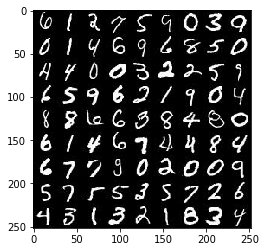

In [2]:
show_n_images = 81

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

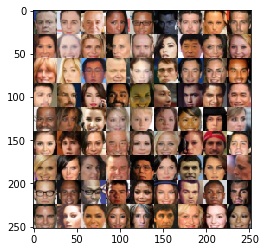

In [3]:
show_n_images = 81

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    r_input = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels),
                              name='r_input')
    z_input = tf.placeholder(dtype=tf.float32,shape=(None, z_dim), name='z_input')
    lr = tf.placeholder(dtype=tf.float32, name='lr')

    return r_input, z_input, lr



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2, dropout=0.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)

        flat = tf.reshape(h3, (-1, 4*4*256))
        dropout_layer = tf.layers.dropout(inputs=flat, rate=dropout)
        logits = tf.layers.dense(dropout_layer, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        h1 = tf.layers.dense(z, 3*3*512)
        h1 = tf.reshape(h1, (-1, 3, 3, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        # 3x3x512
        
        h2 = tf.layers.conv2d_transpose(h1, 256, kernel_size=4, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        # 6x6x256
        
        h3 = tf.layers.conv2d_transpose(h2, 128, kernel_size=4, strides=2, padding='valid')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        #14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, kernel_size=5,strides=2, padding='same')
        out = tf.tanh(logits)
        # 28x28x5
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, dropout=0.8, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha, dropout=dropout)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha, dropout=dropout)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_step = 10
    show_step = 100
    leaky_alpha = 0.2
    dropout = 0.75
    images_to_show = 9
    losses =[]
    step = 0

    _, width, height, channels = data_shape
    
    r_input, z_input, lr = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(r_input, z_input, channels, alpha=leaky_alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print("Starting the training")    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images = 2*batch_images
                # Random Noise as input
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={r_input: batch_images, z_input: z_batch, lr: learning_rate})
                # Let the generator run twice, so that the discriminator does not converge that fast.
                _ = sess.run(g_opt, feed_dict={z_input: z_batch, r_input: batch_images, lr: learning_rate})
                
                if step % print_step == 0:
                    train_loss_d = d_loss.eval({z_input: z_batch, r_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_batch})
                    
                    print("Step: {}:".format(step),
                          "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_step == 0:
                    show_generator_output(sess, images_to_show, z_input, channels, data_image_mode)
    
    print("Finished the training")                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Starting the training
Step: 10: Epoch 1/2... Discriminator Loss: 2.0473... Generator Loss: 0.2917
Step: 20: Epoch 1/2... Discriminator Loss: 2.7745... Generator Loss: 0.1193
Step: 30: Epoch 1/2... Discriminator Loss: 2.6070... Generator Loss: 0.1631
Step: 40: Epoch 1/2... Discriminator Loss: 1.0593... Generator Loss: 0.8662
Step: 50: Epoch 1/2... Discriminator Loss: 1.5302... Generator Loss: 0.5015
Step: 60: Epoch 1/2... Discriminator Loss: 1.6659... Generator Loss: 0.3853
Step: 70: Epoch 1/2... Discriminator Loss: 0.7291... Generator Loss: 1.3733
Step: 80: Epoch 1/2... Discriminator Loss: 0.7806... Generator Loss: 1.4239
Step: 90: Epoch 1/2... Discriminator Loss: 0.9402... Generator Loss: 4.2101
Step: 100: Epoch 1/2... Discriminator Loss: 1.0346... Generator Loss: 0.9117


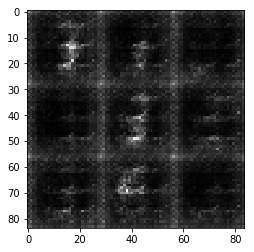

Step: 110: Epoch 1/2... Discriminator Loss: 0.8416... Generator Loss: 1.2262
Step: 120: Epoch 1/2... Discriminator Loss: 1.6811... Generator Loss: 0.4029
Step: 130: Epoch 1/2... Discriminator Loss: 0.9483... Generator Loss: 1.0904
Step: 140: Epoch 1/2... Discriminator Loss: 1.5912... Generator Loss: 0.4270
Step: 150: Epoch 1/2... Discriminator Loss: 1.2071... Generator Loss: 0.6919
Step: 160: Epoch 1/2... Discriminator Loss: 0.8453... Generator Loss: 1.3479
Step: 170: Epoch 1/2... Discriminator Loss: 1.2584... Generator Loss: 0.5911
Step: 180: Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 1.7224
Step: 190: Epoch 1/2... Discriminator Loss: 1.1100... Generator Loss: 2.2934
Step: 200: Epoch 1/2... Discriminator Loss: 0.9395... Generator Loss: 2.2455


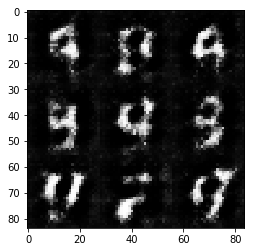

Step: 210: Epoch 1/2... Discriminator Loss: 0.9981... Generator Loss: 1.5784
Step: 220: Epoch 1/2... Discriminator Loss: 0.9233... Generator Loss: 1.1805
Step: 230: Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 0.8214
Step: 240: Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 0.4993
Step: 250: Epoch 1/2... Discriminator Loss: 1.3508... Generator Loss: 0.5385
Step: 260: Epoch 1/2... Discriminator Loss: 1.5009... Generator Loss: 0.4926
Step: 270: Epoch 1/2... Discriminator Loss: 1.0177... Generator Loss: 1.2960
Step: 280: Epoch 1/2... Discriminator Loss: 1.2380... Generator Loss: 1.8088
Step: 290: Epoch 1/2... Discriminator Loss: 1.1569... Generator Loss: 2.1004
Step: 300: Epoch 1/2... Discriminator Loss: 1.0628... Generator Loss: 0.9574


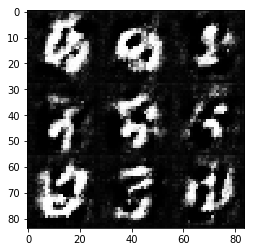

Step: 310: Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 0.9030
Step: 320: Epoch 1/2... Discriminator Loss: 1.0039... Generator Loss: 1.2111
Step: 330: Epoch 1/2... Discriminator Loss: 1.7564... Generator Loss: 0.3424
Step: 340: Epoch 1/2... Discriminator Loss: 1.2246... Generator Loss: 0.6569
Step: 350: Epoch 1/2... Discriminator Loss: 1.1036... Generator Loss: 0.7659
Step: 360: Epoch 1/2... Discriminator Loss: 1.0077... Generator Loss: 1.7266
Step: 370: Epoch 1/2... Discriminator Loss: 0.9003... Generator Loss: 1.8089
Step: 380: Epoch 1/2... Discriminator Loss: 1.0445... Generator Loss: 1.0654
Step: 390: Epoch 1/2... Discriminator Loss: 0.8966... Generator Loss: 1.3290
Step: 400: Epoch 1/2... Discriminator Loss: 0.8933... Generator Loss: 1.4617


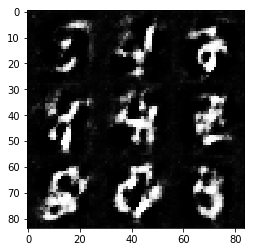

Step: 410: Epoch 1/2... Discriminator Loss: 1.1011... Generator Loss: 0.7549
Step: 420: Epoch 1/2... Discriminator Loss: 1.1065... Generator Loss: 0.7473
Step: 430: Epoch 1/2... Discriminator Loss: 1.2289... Generator Loss: 0.5809
Step: 440: Epoch 1/2... Discriminator Loss: 0.9943... Generator Loss: 1.2823
Step: 450: Epoch 1/2... Discriminator Loss: 0.9832... Generator Loss: 0.9387
Step: 460: Epoch 1/2... Discriminator Loss: 1.2760... Generator Loss: 0.6009
Step: 470: Epoch 1/2... Discriminator Loss: 0.9775... Generator Loss: 1.1873
Step: 480: Epoch 1/2... Discriminator Loss: 1.0257... Generator Loss: 2.1057
Step: 490: Epoch 1/2... Discriminator Loss: 0.9760... Generator Loss: 0.9448
Step: 500: Epoch 1/2... Discriminator Loss: 1.2089... Generator Loss: 0.6654


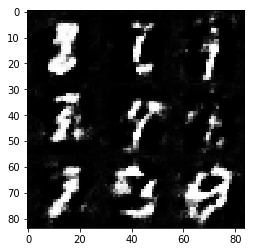

Step: 510: Epoch 1/2... Discriminator Loss: 1.3822... Generator Loss: 0.5515
Step: 520: Epoch 1/2... Discriminator Loss: 1.1734... Generator Loss: 0.6547
Step: 530: Epoch 1/2... Discriminator Loss: 0.9173... Generator Loss: 1.5942
Step: 540: Epoch 1/2... Discriminator Loss: 1.4649... Generator Loss: 0.5136
Step: 550: Epoch 1/2... Discriminator Loss: 0.8799... Generator Loss: 1.1737
Step: 560: Epoch 1/2... Discriminator Loss: 1.0574... Generator Loss: 0.7711
Step: 570: Epoch 1/2... Discriminator Loss: 1.1282... Generator Loss: 0.7592
Step: 580: Epoch 1/2... Discriminator Loss: 0.9166... Generator Loss: 1.8949
Step: 590: Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 1.0640
Step: 600: Epoch 1/2... Discriminator Loss: 0.8447... Generator Loss: 1.1897


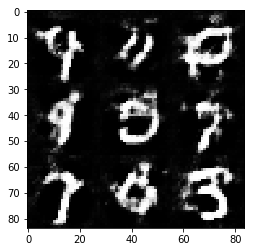

Step: 610: Epoch 1/2... Discriminator Loss: 1.2138... Generator Loss: 0.7340
Step: 620: Epoch 1/2... Discriminator Loss: 1.5679... Generator Loss: 0.3904
Step: 630: Epoch 1/2... Discriminator Loss: 1.0050... Generator Loss: 0.8757
Step: 640: Epoch 1/2... Discriminator Loss: 1.3658... Generator Loss: 0.4967
Step: 650: Epoch 1/2... Discriminator Loss: 1.5728... Generator Loss: 0.4109
Step: 660: Epoch 1/2... Discriminator Loss: 1.3442... Generator Loss: 0.5352
Step: 670: Epoch 1/2... Discriminator Loss: 1.4355... Generator Loss: 0.4594
Step: 680: Epoch 1/2... Discriminator Loss: 0.9421... Generator Loss: 2.0307
Step: 690: Epoch 1/2... Discriminator Loss: 0.9809... Generator Loss: 1.2029
Step: 700: Epoch 1/2... Discriminator Loss: 1.0223... Generator Loss: 0.9419


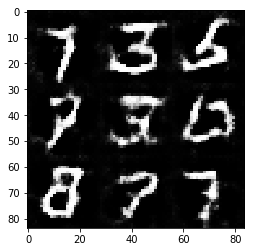

Step: 710: Epoch 1/2... Discriminator Loss: 0.8911... Generator Loss: 1.3529
Step: 720: Epoch 1/2... Discriminator Loss: 0.9826... Generator Loss: 1.3730
Step: 730: Epoch 1/2... Discriminator Loss: 1.6558... Generator Loss: 0.3891
Step: 740: Epoch 1/2... Discriminator Loss: 1.2362... Generator Loss: 0.5784
Step: 750: Epoch 1/2... Discriminator Loss: 1.8015... Generator Loss: 0.3032
Step: 760: Epoch 1/2... Discriminator Loss: 1.0174... Generator Loss: 0.8577
Step: 770: Epoch 1/2... Discriminator Loss: 1.1764... Generator Loss: 0.7128
Step: 780: Epoch 1/2... Discriminator Loss: 0.7762... Generator Loss: 2.1875
Step: 790: Epoch 1/2... Discriminator Loss: 1.0605... Generator Loss: 1.9367
Step: 800: Epoch 1/2... Discriminator Loss: 0.9650... Generator Loss: 1.6422


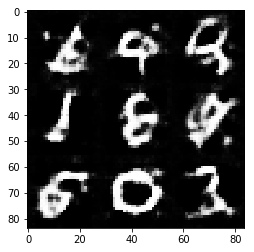

Step: 810: Epoch 1/2... Discriminator Loss: 0.9749... Generator Loss: 1.3929
Step: 820: Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 0.7735
Step: 830: Epoch 1/2... Discriminator Loss: 1.0755... Generator Loss: 0.7580
Step: 840: Epoch 1/2... Discriminator Loss: 1.6808... Generator Loss: 0.3507
Step: 850: Epoch 1/2... Discriminator Loss: 0.9312... Generator Loss: 1.4251
Step: 860: Epoch 1/2... Discriminator Loss: 0.8401... Generator Loss: 1.6103
Step: 870: Epoch 1/2... Discriminator Loss: 1.6740... Generator Loss: 0.4023
Step: 880: Epoch 1/2... Discriminator Loss: 1.0943... Generator Loss: 0.8133
Step: 890: Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 0.5945
Step: 900: Epoch 1/2... Discriminator Loss: 0.9301... Generator Loss: 2.0488


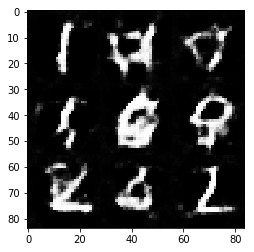

Step: 910: Epoch 1/2... Discriminator Loss: 1.2165... Generator Loss: 0.6447
Step: 920: Epoch 1/2... Discriminator Loss: 1.4417... Generator Loss: 0.4522
Step: 930: Epoch 1/2... Discriminator Loss: 1.0439... Generator Loss: 1.0773
Step: 940: Epoch 1/2... Discriminator Loss: 0.9305... Generator Loss: 1.2412
Step: 950: Epoch 1/2... Discriminator Loss: 1.0148... Generator Loss: 0.9679
Step: 960: Epoch 1/2... Discriminator Loss: 1.2986... Generator Loss: 2.4065
Step: 970: Epoch 1/2... Discriminator Loss: 0.9955... Generator Loss: 0.8977
Step: 980: Epoch 1/2... Discriminator Loss: 1.1228... Generator Loss: 0.6876
Step: 990: Epoch 1/2... Discriminator Loss: 1.2157... Generator Loss: 0.6194
Step: 1000: Epoch 1/2... Discriminator Loss: 1.1773... Generator Loss: 0.6370


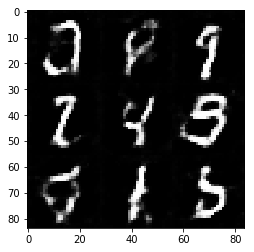

Step: 1010: Epoch 1/2... Discriminator Loss: 1.2731... Generator Loss: 0.5596
Step: 1020: Epoch 1/2... Discriminator Loss: 0.9276... Generator Loss: 1.1921
Step: 1030: Epoch 1/2... Discriminator Loss: 0.9673... Generator Loss: 1.1408
Step: 1040: Epoch 1/2... Discriminator Loss: 1.4181... Generator Loss: 0.5233
Step: 1050: Epoch 1/2... Discriminator Loss: 0.9508... Generator Loss: 1.3140
Step: 1060: Epoch 1/2... Discriminator Loss: 0.9521... Generator Loss: 1.0605
Step: 1070: Epoch 1/2... Discriminator Loss: 0.7891... Generator Loss: 1.9408
Step: 1080: Epoch 1/2... Discriminator Loss: 1.6136... Generator Loss: 0.4237
Step: 1090: Epoch 1/2... Discriminator Loss: 0.9561... Generator Loss: 1.0962
Step: 1100: Epoch 1/2... Discriminator Loss: 0.8481... Generator Loss: 1.2551


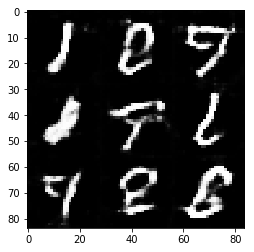

Step: 1110: Epoch 1/2... Discriminator Loss: 1.3169... Generator Loss: 0.5945
Step: 1120: Epoch 1/2... Discriminator Loss: 0.8927... Generator Loss: 1.0577
Step: 1130: Epoch 1/2... Discriminator Loss: 1.4927... Generator Loss: 0.4726
Step: 1140: Epoch 1/2... Discriminator Loss: 0.8961... Generator Loss: 1.1176
Step: 1150: Epoch 1/2... Discriminator Loss: 1.0093... Generator Loss: 1.8018
Step: 1160: Epoch 1/2... Discriminator Loss: 0.9561... Generator Loss: 1.1274
Step: 1170: Epoch 1/2... Discriminator Loss: 0.9837... Generator Loss: 1.7355
Step: 1180: Epoch 1/2... Discriminator Loss: 0.9120... Generator Loss: 1.2439
Step: 1190: Epoch 1/2... Discriminator Loss: 0.8173... Generator Loss: 1.7526
Step: 1200: Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.4940


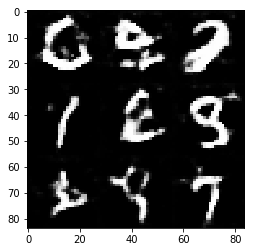

Step: 1210: Epoch 1/2... Discriminator Loss: 0.8991... Generator Loss: 1.2835
Step: 1220: Epoch 1/2... Discriminator Loss: 0.8944... Generator Loss: 1.1124
Step: 1230: Epoch 1/2... Discriminator Loss: 0.9513... Generator Loss: 0.8608
Step: 1240: Epoch 1/2... Discriminator Loss: 0.8867... Generator Loss: 1.5524
Step: 1250: Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 0.5635
Step: 1260: Epoch 1/2... Discriminator Loss: 1.2108... Generator Loss: 0.8051
Step: 1270: Epoch 1/2... Discriminator Loss: 0.9892... Generator Loss: 0.8858
Step: 1280: Epoch 1/2... Discriminator Loss: 1.0429... Generator Loss: 0.8074
Step: 1290: Epoch 1/2... Discriminator Loss: 1.0112... Generator Loss: 0.8267
Step: 1300: Epoch 1/2... Discriminator Loss: 0.8160... Generator Loss: 1.2506


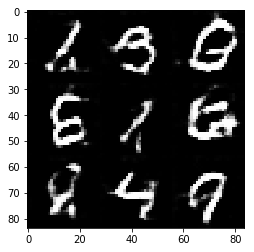

Step: 1310: Epoch 1/2... Discriminator Loss: 0.9989... Generator Loss: 0.8325
Step: 1320: Epoch 1/2... Discriminator Loss: 1.2582... Generator Loss: 0.5739
Step: 1330: Epoch 1/2... Discriminator Loss: 0.8503... Generator Loss: 1.1164
Step: 1340: Epoch 1/2... Discriminator Loss: 0.7994... Generator Loss: 1.3131
Step: 1350: Epoch 1/2... Discriminator Loss: 2.7842... Generator Loss: 0.1835
Step: 1360: Epoch 1/2... Discriminator Loss: 1.3159... Generator Loss: 0.5667
Step: 1370: Epoch 1/2... Discriminator Loss: 0.9327... Generator Loss: 1.1358
Step: 1380: Epoch 1/2... Discriminator Loss: 0.9319... Generator Loss: 1.0094
Step: 1390: Epoch 1/2... Discriminator Loss: 0.8842... Generator Loss: 1.0481
Step: 1400: Epoch 1/2... Discriminator Loss: 0.8952... Generator Loss: 0.9961


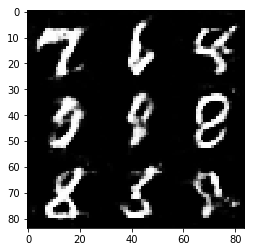

Step: 1410: Epoch 1/2... Discriminator Loss: 0.8183... Generator Loss: 1.2417
Step: 1420: Epoch 1/2... Discriminator Loss: 0.7855... Generator Loss: 1.8422
Step: 1430: Epoch 1/2... Discriminator Loss: 0.8539... Generator Loss: 2.0288
Step: 1440: Epoch 1/2... Discriminator Loss: 0.8461... Generator Loss: 1.0828
Step: 1450: Epoch 1/2... Discriminator Loss: 0.7301... Generator Loss: 1.8310
Step: 1460: Epoch 1/2... Discriminator Loss: 1.2718... Generator Loss: 0.5712
Step: 1470: Epoch 1/2... Discriminator Loss: 0.7570... Generator Loss: 1.3414
Step: 1480: Epoch 1/2... Discriminator Loss: 0.8512... Generator Loss: 1.0444
Step: 1490: Epoch 1/2... Discriminator Loss: 5.5918... Generator Loss: 7.7157
Step: 1500: Epoch 1/2... Discriminator Loss: 1.3722... Generator Loss: 0.5328


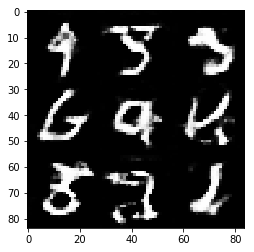

Step: 1510: Epoch 1/2... Discriminator Loss: 1.2438... Generator Loss: 0.6490
Step: 1520: Epoch 1/2... Discriminator Loss: 0.6771... Generator Loss: 1.4720
Step: 1530: Epoch 1/2... Discriminator Loss: 0.9529... Generator Loss: 0.8744
Step: 1540: Epoch 1/2... Discriminator Loss: 0.7902... Generator Loss: 1.3227
Step: 1550: Epoch 1/2... Discriminator Loss: 0.7768... Generator Loss: 1.2356
Step: 1560: Epoch 1/2... Discriminator Loss: 0.6477... Generator Loss: 1.7229
Step: 1570: Epoch 1/2... Discriminator Loss: 0.9190... Generator Loss: 1.0047
Step: 1580: Epoch 1/2... Discriminator Loss: 0.6367... Generator Loss: 1.5508
Step: 1590: Epoch 1/2... Discriminator Loss: 0.6772... Generator Loss: 1.4489
Step: 1600: Epoch 1/2... Discriminator Loss: 0.9418... Generator Loss: 0.9570


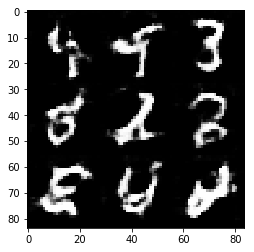

Step: 1610: Epoch 1/2... Discriminator Loss: 1.5287... Generator Loss: 2.4949
Step: 1620: Epoch 1/2... Discriminator Loss: 0.9954... Generator Loss: 0.8876
Step: 1630: Epoch 1/2... Discriminator Loss: 0.9697... Generator Loss: 0.9163
Step: 1640: Epoch 1/2... Discriminator Loss: 0.7766... Generator Loss: 1.1344
Step: 1650: Epoch 1/2... Discriminator Loss: 0.6734... Generator Loss: 1.4622
Step: 1660: Epoch 1/2... Discriminator Loss: 0.9056... Generator Loss: 0.9850
Step: 1670: Epoch 1/2... Discriminator Loss: 0.6824... Generator Loss: 1.4126
Step: 1680: Epoch 1/2... Discriminator Loss: 0.8810... Generator Loss: 1.1069
Step: 1690: Epoch 1/2... Discriminator Loss: 1.5720... Generator Loss: 0.4094
Step: 1700: Epoch 1/2... Discriminator Loss: 0.9756... Generator Loss: 1.0842


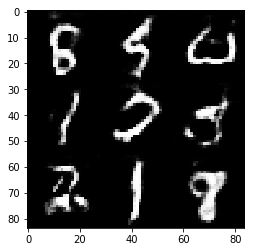

Step: 1710: Epoch 1/2... Discriminator Loss: 0.8196... Generator Loss: 1.2879
Step: 1720: Epoch 1/2... Discriminator Loss: 0.8407... Generator Loss: 1.1099
Step: 1730: Epoch 1/2... Discriminator Loss: 0.7157... Generator Loss: 1.3213
Step: 1740: Epoch 1/2... Discriminator Loss: 0.7842... Generator Loss: 1.2588
Step: 1750: Epoch 1/2... Discriminator Loss: 1.1639... Generator Loss: 0.6375
Step: 1760: Epoch 1/2... Discriminator Loss: 0.6951... Generator Loss: 2.0546
Step: 1770: Epoch 1/2... Discriminator Loss: 0.9819... Generator Loss: 0.8718
Step: 1780: Epoch 1/2... Discriminator Loss: 0.6616... Generator Loss: 1.8475
Step: 1790: Epoch 1/2... Discriminator Loss: 0.7312... Generator Loss: 1.4384
Step: 1800: Epoch 1/2... Discriminator Loss: 1.1013... Generator Loss: 1.6052


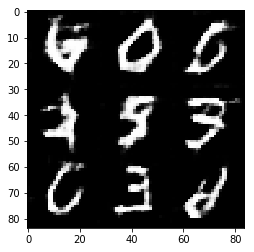

Step: 1810: Epoch 1/2... Discriminator Loss: 1.0212... Generator Loss: 0.8494
Step: 1820: Epoch 1/2... Discriminator Loss: 0.6560... Generator Loss: 1.7571
Step: 1830: Epoch 1/2... Discriminator Loss: 1.0471... Generator Loss: 0.7665
Step: 1840: Epoch 1/2... Discriminator Loss: 0.9814... Generator Loss: 0.8601
Step: 1850: Epoch 1/2... Discriminator Loss: 0.7579... Generator Loss: 1.2650
Step: 1860: Epoch 1/2... Discriminator Loss: 1.2151... Generator Loss: 0.6338
Step: 1870: Epoch 1/2... Discriminator Loss: 0.9499... Generator Loss: 0.9115
Step: 1880: Epoch 2/2... Discriminator Loss: 0.6819... Generator Loss: 1.4519
Step: 1890: Epoch 2/2... Discriminator Loss: 1.4616... Generator Loss: 0.5410
Step: 1900: Epoch 2/2... Discriminator Loss: 1.1580... Generator Loss: 0.7066


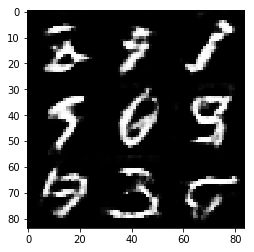

Step: 1910: Epoch 2/2... Discriminator Loss: 0.7546... Generator Loss: 1.3556
Step: 1920: Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 0.9574
Step: 1930: Epoch 2/2... Discriminator Loss: 1.1326... Generator Loss: 0.7275
Step: 1940: Epoch 2/2... Discriminator Loss: 0.9048... Generator Loss: 0.9442
Step: 1950: Epoch 2/2... Discriminator Loss: 0.8005... Generator Loss: 1.2904
Step: 1960: Epoch 2/2... Discriminator Loss: 0.7554... Generator Loss: 1.2919
Step: 1970: Epoch 2/2... Discriminator Loss: 0.7588... Generator Loss: 1.2071
Step: 1980: Epoch 2/2... Discriminator Loss: 3.9242... Generator Loss: 0.0826
Step: 1990: Epoch 2/2... Discriminator Loss: 1.1269... Generator Loss: 0.7606
Step: 2000: Epoch 2/2... Discriminator Loss: 0.7609... Generator Loss: 1.3068


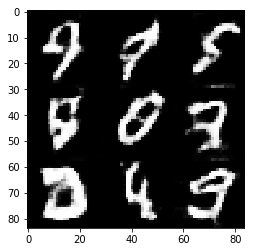

Step: 2010: Epoch 2/2... Discriminator Loss: 0.9518... Generator Loss: 0.9014
Step: 2020: Epoch 2/2... Discriminator Loss: 0.9283... Generator Loss: 0.9660
Step: 2030: Epoch 2/2... Discriminator Loss: 1.5866... Generator Loss: 2.3772
Step: 2040: Epoch 2/2... Discriminator Loss: 0.6745... Generator Loss: 1.4252
Step: 2050: Epoch 2/2... Discriminator Loss: 0.9129... Generator Loss: 0.9744
Step: 2060: Epoch 2/2... Discriminator Loss: 1.0518... Generator Loss: 0.7405
Step: 2070: Epoch 2/2... Discriminator Loss: 0.7525... Generator Loss: 1.2261
Step: 2080: Epoch 2/2... Discriminator Loss: 0.8651... Generator Loss: 1.2279
Step: 2090: Epoch 2/2... Discriminator Loss: 0.9406... Generator Loss: 0.8976
Step: 2100: Epoch 2/2... Discriminator Loss: 0.9400... Generator Loss: 0.9324


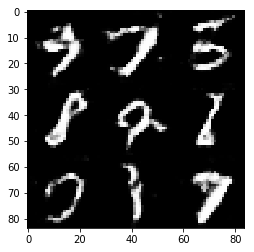

Step: 2110: Epoch 2/2... Discriminator Loss: 3.2333... Generator Loss: 0.1135
Step: 2120: Epoch 2/2... Discriminator Loss: 0.7486... Generator Loss: 1.3235
Step: 2130: Epoch 2/2... Discriminator Loss: 0.8822... Generator Loss: 1.0151
Step: 2140: Epoch 2/2... Discriminator Loss: 0.8069... Generator Loss: 1.2096
Step: 2150: Epoch 2/2... Discriminator Loss: 1.4207... Generator Loss: 0.4986
Step: 2160: Epoch 2/2... Discriminator Loss: 0.6664... Generator Loss: 1.5436
Step: 2170: Epoch 2/2... Discriminator Loss: 0.8893... Generator Loss: 0.9808
Step: 2180: Epoch 2/2... Discriminator Loss: 0.8722... Generator Loss: 0.9765
Step: 2190: Epoch 2/2... Discriminator Loss: 0.7449... Generator Loss: 1.2145
Step: 2200: Epoch 2/2... Discriminator Loss: 0.7406... Generator Loss: 1.2968


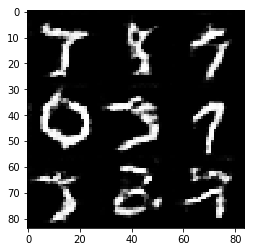

Step: 2210: Epoch 2/2... Discriminator Loss: 0.6482... Generator Loss: 1.7963
Step: 2220: Epoch 2/2... Discriminator Loss: 1.5055... Generator Loss: 0.4326
Step: 2230: Epoch 2/2... Discriminator Loss: 0.9857... Generator Loss: 0.8320
Step: 2240: Epoch 2/2... Discriminator Loss: 0.6290... Generator Loss: 1.5610
Step: 2250: Epoch 2/2... Discriminator Loss: 0.6753... Generator Loss: 1.5112
Step: 2260: Epoch 2/2... Discriminator Loss: 0.6966... Generator Loss: 1.3642
Step: 2270: Epoch 2/2... Discriminator Loss: 0.5695... Generator Loss: 1.7957
Step: 2280: Epoch 2/2... Discriminator Loss: 1.2845... Generator Loss: 0.5690
Step: 2290: Epoch 2/2... Discriminator Loss: 0.9426... Generator Loss: 1.3350
Step: 2300: Epoch 2/2... Discriminator Loss: 1.9600... Generator Loss: 0.3910


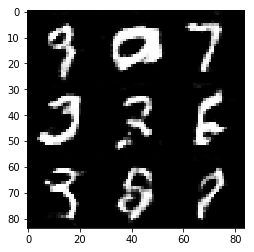

Step: 2310: Epoch 2/2... Discriminator Loss: 0.7803... Generator Loss: 1.2159
Step: 2320: Epoch 2/2... Discriminator Loss: 1.3930... Generator Loss: 0.5553
Step: 2330: Epoch 2/2... Discriminator Loss: 1.0407... Generator Loss: 0.8063
Step: 2340: Epoch 2/2... Discriminator Loss: 0.7838... Generator Loss: 1.5811
Step: 2350: Epoch 2/2... Discriminator Loss: 0.6977... Generator Loss: 1.3952
Step: 2360: Epoch 2/2... Discriminator Loss: 0.7163... Generator Loss: 2.5619
Step: 2370: Epoch 2/2... Discriminator Loss: 0.8624... Generator Loss: 1.0512
Step: 2380: Epoch 2/2... Discriminator Loss: 1.5214... Generator Loss: 3.6260
Step: 2390: Epoch 2/2... Discriminator Loss: 0.8229... Generator Loss: 1.1226
Step: 2400: Epoch 2/2... Discriminator Loss: 1.1076... Generator Loss: 0.7321


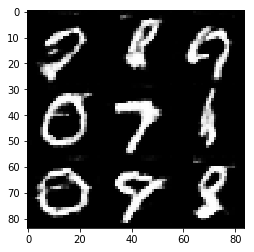

Step: 2410: Epoch 2/2... Discriminator Loss: 0.9449... Generator Loss: 0.9042
Step: 2420: Epoch 2/2... Discriminator Loss: 0.7608... Generator Loss: 1.7913
Step: 2430: Epoch 2/2... Discriminator Loss: 0.7190... Generator Loss: 1.3475
Step: 2440: Epoch 2/2... Discriminator Loss: 0.8516... Generator Loss: 1.0941
Step: 2450: Epoch 2/2... Discriminator Loss: 0.9194... Generator Loss: 1.0615
Step: 2460: Epoch 2/2... Discriminator Loss: 0.6501... Generator Loss: 1.4703
Step: 2470: Epoch 2/2... Discriminator Loss: 1.4858... Generator Loss: 0.5000
Step: 2480: Epoch 2/2... Discriminator Loss: 0.7491... Generator Loss: 2.0055
Step: 2490: Epoch 2/2... Discriminator Loss: 0.7519... Generator Loss: 1.2322
Step: 2500: Epoch 2/2... Discriminator Loss: 1.0668... Generator Loss: 0.7359


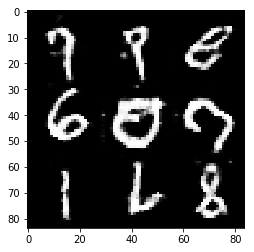

Step: 2510: Epoch 2/2... Discriminator Loss: 0.6131... Generator Loss: 1.8188
Step: 2520: Epoch 2/2... Discriminator Loss: 0.8230... Generator Loss: 1.1883
Step: 2530: Epoch 2/2... Discriminator Loss: 0.7448... Generator Loss: 1.4776
Step: 2540: Epoch 2/2... Discriminator Loss: 1.0168... Generator Loss: 0.7912
Step: 2550: Epoch 2/2... Discriminator Loss: 1.4454... Generator Loss: 0.4858
Step: 2560: Epoch 2/2... Discriminator Loss: 2.8749... Generator Loss: 0.1821
Step: 2570: Epoch 2/2... Discriminator Loss: 1.1518... Generator Loss: 0.7968
Step: 2580: Epoch 2/2... Discriminator Loss: 1.1494... Generator Loss: 0.7026
Step: 2590: Epoch 2/2... Discriminator Loss: 0.8000... Generator Loss: 1.0787
Step: 2600: Epoch 2/2... Discriminator Loss: 0.9031... Generator Loss: 0.9652


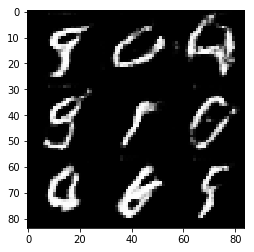

Step: 2610: Epoch 2/2... Discriminator Loss: 1.7225... Generator Loss: 3.7531
Step: 2620: Epoch 2/2... Discriminator Loss: 1.8942... Generator Loss: 0.3133
Step: 2630: Epoch 2/2... Discriminator Loss: 1.1109... Generator Loss: 0.7139
Step: 2640: Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 1.1050
Step: 2650: Epoch 2/2... Discriminator Loss: 0.6339... Generator Loss: 1.5199
Step: 2660: Epoch 2/2... Discriminator Loss: 0.7769... Generator Loss: 1.1897
Step: 2670: Epoch 2/2... Discriminator Loss: 0.7124... Generator Loss: 1.4408
Step: 2680: Epoch 2/2... Discriminator Loss: 1.0256... Generator Loss: 0.8849
Step: 2690: Epoch 2/2... Discriminator Loss: 0.5533... Generator Loss: 2.2499
Step: 2700: Epoch 2/2... Discriminator Loss: 0.8224... Generator Loss: 1.1667


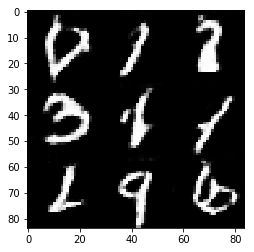

Step: 2710: Epoch 2/2... Discriminator Loss: 0.9967... Generator Loss: 0.8207
Step: 2720: Epoch 2/2... Discriminator Loss: 0.6875... Generator Loss: 1.3402
Step: 2730: Epoch 2/2... Discriminator Loss: 0.6095... Generator Loss: 1.6472
Step: 2740: Epoch 2/2... Discriminator Loss: 0.7232... Generator Loss: 1.2955
Step: 2750: Epoch 2/2... Discriminator Loss: 0.7829... Generator Loss: 1.3324
Step: 2760: Epoch 2/2... Discriminator Loss: 0.6962... Generator Loss: 1.4244
Step: 2770: Epoch 2/2... Discriminator Loss: 0.7431... Generator Loss: 1.2368
Step: 2780: Epoch 2/2... Discriminator Loss: 0.7303... Generator Loss: 2.1915
Step: 2790: Epoch 2/2... Discriminator Loss: 1.3361... Generator Loss: 0.6263
Step: 2800: Epoch 2/2... Discriminator Loss: 0.9507... Generator Loss: 0.8742


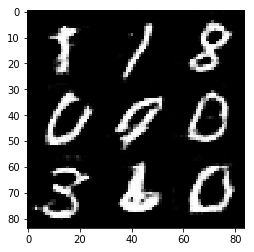

Step: 2810: Epoch 2/2... Discriminator Loss: 0.6862... Generator Loss: 1.6023
Step: 2820: Epoch 2/2... Discriminator Loss: 0.8549... Generator Loss: 1.1125
Step: 2830: Epoch 2/2... Discriminator Loss: 1.6621... Generator Loss: 0.4906
Step: 2840: Epoch 2/2... Discriminator Loss: 0.6681... Generator Loss: 1.4784
Step: 2850: Epoch 2/2... Discriminator Loss: 0.7391... Generator Loss: 1.5598
Step: 2860: Epoch 2/2... Discriminator Loss: 0.5593... Generator Loss: 1.8025
Step: 2870: Epoch 2/2... Discriminator Loss: 0.6243... Generator Loss: 2.1784
Step: 2880: Epoch 2/2... Discriminator Loss: 1.6464... Generator Loss: 0.4560
Step: 2890: Epoch 2/2... Discriminator Loss: 1.3386... Generator Loss: 0.5552
Step: 2900: Epoch 2/2... Discriminator Loss: 0.8316... Generator Loss: 1.0955


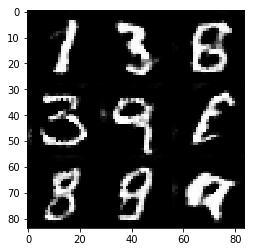

Step: 2910: Epoch 2/2... Discriminator Loss: 0.6054... Generator Loss: 1.6720
Step: 2920: Epoch 2/2... Discriminator Loss: 0.5792... Generator Loss: 2.0143
Step: 2930: Epoch 2/2... Discriminator Loss: 1.0409... Generator Loss: 0.8149
Step: 2940: Epoch 2/2... Discriminator Loss: 0.7871... Generator Loss: 1.2697
Step: 2950: Epoch 2/2... Discriminator Loss: 0.7911... Generator Loss: 1.3728
Step: 2960: Epoch 2/2... Discriminator Loss: 0.7725... Generator Loss: 1.2958
Step: 2970: Epoch 2/2... Discriminator Loss: 0.5875... Generator Loss: 1.8181
Step: 2980: Epoch 2/2... Discriminator Loss: 0.5492... Generator Loss: 1.9732
Step: 2990: Epoch 2/2... Discriminator Loss: 1.0522... Generator Loss: 0.8824
Step: 3000: Epoch 2/2... Discriminator Loss: 1.2981... Generator Loss: 0.7157


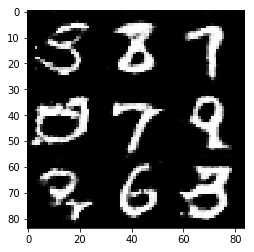

Step: 3010: Epoch 2/2... Discriminator Loss: 2.3090... Generator Loss: 0.2622
Step: 3020: Epoch 2/2... Discriminator Loss: 1.1809... Generator Loss: 0.7370
Step: 3030: Epoch 2/2... Discriminator Loss: 0.5813... Generator Loss: 1.7628
Step: 3040: Epoch 2/2... Discriminator Loss: 0.7925... Generator Loss: 1.3659
Step: 3050: Epoch 2/2... Discriminator Loss: 0.7495... Generator Loss: 1.3029
Step: 3060: Epoch 2/2... Discriminator Loss: 0.8965... Generator Loss: 0.9877
Step: 3070: Epoch 2/2... Discriminator Loss: 0.5918... Generator Loss: 2.0545
Step: 3080: Epoch 2/2... Discriminator Loss: 0.7055... Generator Loss: 1.3245
Step: 3090: Epoch 2/2... Discriminator Loss: 0.8662... Generator Loss: 1.4968
Step: 3100: Epoch 2/2... Discriminator Loss: 0.8695... Generator Loss: 1.7634


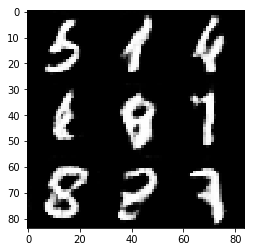

Step: 3110: Epoch 2/2... Discriminator Loss: 0.7262... Generator Loss: 1.2546
Step: 3120: Epoch 2/2... Discriminator Loss: 0.6556... Generator Loss: 1.6091
Step: 3130: Epoch 2/2... Discriminator Loss: 0.8855... Generator Loss: 0.9494
Step: 3140: Epoch 2/2... Discriminator Loss: 1.6987... Generator Loss: 3.6813
Step: 3150: Epoch 2/2... Discriminator Loss: 0.9537... Generator Loss: 0.9784
Step: 3160: Epoch 2/2... Discriminator Loss: 0.7536... Generator Loss: 1.3441
Step: 3170: Epoch 2/2... Discriminator Loss: 1.2479... Generator Loss: 0.7366
Step: 3180: Epoch 2/2... Discriminator Loss: 0.8705... Generator Loss: 1.1437
Step: 3190: Epoch 2/2... Discriminator Loss: 0.5920... Generator Loss: 1.6707
Step: 3200: Epoch 2/2... Discriminator Loss: 0.6274... Generator Loss: 1.6231


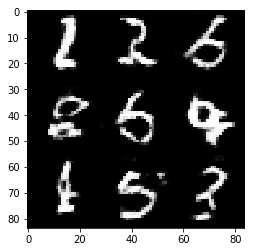

Step: 3210: Epoch 2/2... Discriminator Loss: 1.0722... Generator Loss: 0.7696
Step: 3220: Epoch 2/2... Discriminator Loss: 0.5823... Generator Loss: 1.7581
Step: 3230: Epoch 2/2... Discriminator Loss: 0.7656... Generator Loss: 1.6053
Step: 3240: Epoch 2/2... Discriminator Loss: 1.1457... Generator Loss: 0.7662
Step: 3250: Epoch 2/2... Discriminator Loss: 0.7915... Generator Loss: 1.2552
Step: 3260: Epoch 2/2... Discriminator Loss: 0.5968... Generator Loss: 1.7793
Step: 3270: Epoch 2/2... Discriminator Loss: 1.2842... Generator Loss: 0.6108
Step: 3280: Epoch 2/2... Discriminator Loss: 0.5443... Generator Loss: 2.1163
Step: 3290: Epoch 2/2... Discriminator Loss: 0.6325... Generator Loss: 1.5985
Step: 3300: Epoch 2/2... Discriminator Loss: 1.2167... Generator Loss: 0.6814


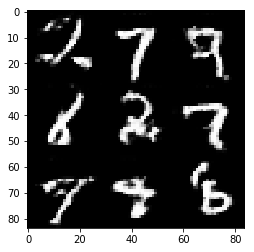

Step: 3310: Epoch 2/2... Discriminator Loss: 0.6247... Generator Loss: 2.1403
Step: 3320: Epoch 2/2... Discriminator Loss: 0.7026... Generator Loss: 1.4106
Step: 3330: Epoch 2/2... Discriminator Loss: 0.7040... Generator Loss: 1.4714
Step: 3340: Epoch 2/2... Discriminator Loss: 1.3145... Generator Loss: 0.6131
Step: 3350: Epoch 2/2... Discriminator Loss: 0.7682... Generator Loss: 1.2332
Step: 3360: Epoch 2/2... Discriminator Loss: 0.8559... Generator Loss: 1.1455
Step: 3370: Epoch 2/2... Discriminator Loss: 0.5963... Generator Loss: 1.7879
Step: 3380: Epoch 2/2... Discriminator Loss: 0.5916... Generator Loss: 1.6972
Step: 3390: Epoch 2/2... Discriminator Loss: 0.5561... Generator Loss: 1.9235
Step: 3400: Epoch 2/2... Discriminator Loss: 0.5988... Generator Loss: 2.1313


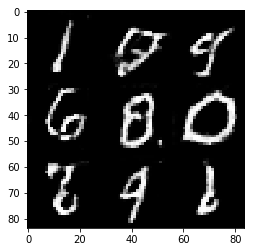

Step: 3410: Epoch 2/2... Discriminator Loss: 1.7001... Generator Loss: 0.4612
Step: 3420: Epoch 2/2... Discriminator Loss: 0.7335... Generator Loss: 2.8341
Step: 3430: Epoch 2/2... Discriminator Loss: 0.7003... Generator Loss: 1.4761
Step: 3440: Epoch 2/2... Discriminator Loss: 0.8221... Generator Loss: 2.5754
Step: 3450: Epoch 2/2... Discriminator Loss: 0.8177... Generator Loss: 1.1468
Step: 3460: Epoch 2/2... Discriminator Loss: 0.7364... Generator Loss: 1.3435
Step: 3470: Epoch 2/2... Discriminator Loss: 0.6048... Generator Loss: 1.6654
Step: 3480: Epoch 2/2... Discriminator Loss: 0.5808... Generator Loss: 1.8388
Step: 3490: Epoch 2/2... Discriminator Loss: 1.0755... Generator Loss: 3.0595
Step: 3500: Epoch 2/2... Discriminator Loss: 0.7590... Generator Loss: 1.3325


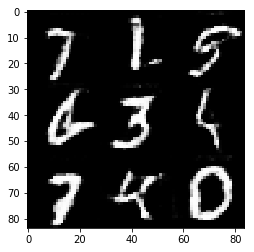

Step: 3510: Epoch 2/2... Discriminator Loss: 1.2175... Generator Loss: 0.6925
Step: 3520: Epoch 2/2... Discriminator Loss: 0.6165... Generator Loss: 1.6121
Step: 3530: Epoch 2/2... Discriminator Loss: 0.7098... Generator Loss: 1.3776
Step: 3540: Epoch 2/2... Discriminator Loss: 0.5740... Generator Loss: 1.7828
Step: 3550: Epoch 2/2... Discriminator Loss: 0.5993... Generator Loss: 2.1189
Step: 3560: Epoch 2/2... Discriminator Loss: 1.5576... Generator Loss: 3.7013
Step: 3570: Epoch 2/2... Discriminator Loss: 0.6146... Generator Loss: 1.9053
Step: 3580: Epoch 2/2... Discriminator Loss: 0.8807... Generator Loss: 3.5231
Step: 3590: Epoch 2/2... Discriminator Loss: 1.0056... Generator Loss: 0.8883
Step: 3600: Epoch 2/2... Discriminator Loss: 0.6281... Generator Loss: 1.6485


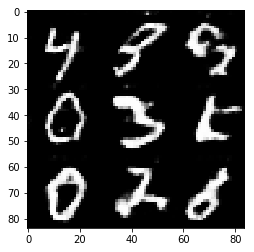

Step: 3610: Epoch 2/2... Discriminator Loss: 1.2074... Generator Loss: 0.6817
Step: 3620: Epoch 2/2... Discriminator Loss: 0.5419... Generator Loss: 2.0917
Step: 3630: Epoch 2/2... Discriminator Loss: 0.9294... Generator Loss: 0.9790
Step: 3640: Epoch 2/2... Discriminator Loss: 0.8470... Generator Loss: 1.0685
Step: 3650: Epoch 2/2... Discriminator Loss: 0.8509... Generator Loss: 1.1104
Step: 3660: Epoch 2/2... Discriminator Loss: 0.6046... Generator Loss: 1.9510
Step: 3670: Epoch 2/2... Discriminator Loss: 0.7071... Generator Loss: 1.3572
Step: 3680: Epoch 2/2... Discriminator Loss: 0.6304... Generator Loss: 1.7464
Step: 3690: Epoch 2/2... Discriminator Loss: 0.6255... Generator Loss: 1.4878
Step: 3700: Epoch 2/2... Discriminator Loss: 1.5416... Generator Loss: 0.6341


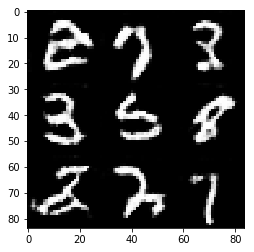

Step: 3710: Epoch 2/2... Discriminator Loss: 0.6867... Generator Loss: 2.1297
Step: 3720: Epoch 2/2... Discriminator Loss: 0.7521... Generator Loss: 1.6631
Step: 3730: Epoch 2/2... Discriminator Loss: 0.8733... Generator Loss: 1.0519
Step: 3740: Epoch 2/2... Discriminator Loss: 0.9864... Generator Loss: 0.8384
Step: 3750: Epoch 2/2... Discriminator Loss: 0.6993... Generator Loss: 1.3529
Finished the training


In [19]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Starting the training
Step: 10: Epoch 1/1... Discriminator Loss: 1.7313... Generator Loss: 0.4734
Step: 20: Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 1.2644
Step: 30: Epoch 1/1... Discriminator Loss: 1.9894... Generator Loss: 10.8756
Step: 40: Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.1300
Step: 50: Epoch 1/1... Discriminator Loss: 0.5198... Generator Loss: 4.6338
Step: 60: Epoch 1/1... Discriminator Loss: 1.7930... Generator Loss: 0.3324
Step: 70: Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 1.2382
Step: 80: Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.2352
Step: 90: Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.6758
Step: 100: Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 1.3357


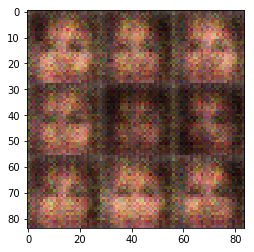

Step: 110: Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.5474
Step: 120: Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 1.1978
Step: 130: Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 1.9169
Step: 140: Epoch 1/1... Discriminator Loss: 1.9340... Generator Loss: 0.2807
Step: 150: Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 2.1251
Step: 160: Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 1.8004
Step: 170: Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.5324
Step: 180: Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.0160
Step: 190: Epoch 1/1... Discriminator Loss: 1.6127... Generator Loss: 0.4245
Step: 200: Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 2.3482


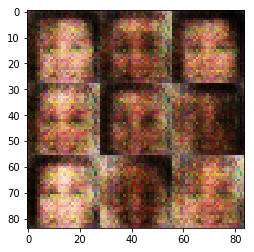

Step: 210: Epoch 1/1... Discriminator Loss: 1.6677... Generator Loss: 0.3835
Step: 220: Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.6841
Step: 230: Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 1.0267
Step: 240: Epoch 1/1... Discriminator Loss: 1.9773... Generator Loss: 5.0754
Step: 250: Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.6712
Step: 260: Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.2119
Step: 270: Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.9123
Step: 280: Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.9008
Step: 290: Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 1.1681
Step: 300: Epoch 1/1... Discriminator Loss: 1.8386... Generator Loss: 0.3249


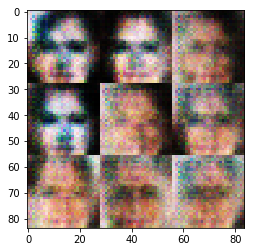

Step: 310: Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 2.0256
Step: 320: Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.4925
Step: 330: Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 2.3358
Step: 340: Epoch 1/1... Discriminator Loss: 0.5657... Generator Loss: 2.2576
Step: 350: Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 0.8018
Step: 360: Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 2.7969
Step: 370: Epoch 1/1... Discriminator Loss: 0.8886... Generator Loss: 2.3673
Step: 380: Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 1.7214
Step: 390: Epoch 1/1... Discriminator Loss: 2.0370... Generator Loss: 0.2162
Step: 400: Epoch 1/1... Discriminator Loss: 2.0431... Generator Loss: 0.2519


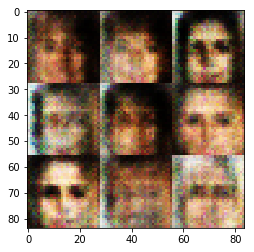

Step: 410: Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.7457
Step: 420: Epoch 1/1... Discriminator Loss: 0.7475... Generator Loss: 2.3890
Step: 430: Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 1.9577
Step: 440: Epoch 1/1... Discriminator Loss: 1.6333... Generator Loss: 0.4302
Step: 450: Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 2.8002
Step: 460: Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 2.5038
Step: 470: Epoch 1/1... Discriminator Loss: 0.6947... Generator Loss: 1.5769
Step: 480: Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 1.3031
Step: 490: Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 1.9816
Step: 500: Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 1.8549


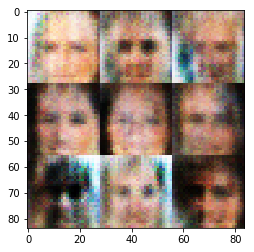

Step: 510: Epoch 1/1... Discriminator Loss: 2.2976... Generator Loss: 0.2364
Step: 520: Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 0.8902
Step: 530: Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 2.4975
Step: 540: Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 1.2998
Step: 550: Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 1.1881
Step: 560: Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 1.9708
Step: 570: Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.6170
Step: 580: Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.6045
Step: 590: Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.4313
Step: 600: Epoch 1/1... Discriminator Loss: 1.7420... Generator Loss: 0.3659


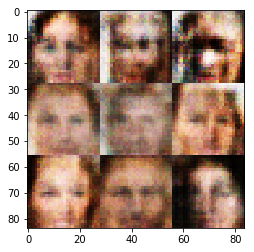

Step: 610: Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 1.0015
Step: 620: Epoch 1/1... Discriminator Loss: 1.7365... Generator Loss: 0.3287
Step: 630: Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 0.8167
Step: 640: Epoch 1/1... Discriminator Loss: 0.8109... Generator Loss: 1.7298
Step: 650: Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 2.5161
Step: 660: Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 2.7616
Step: 670: Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 2.5069
Step: 680: Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.6128
Step: 690: Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 1.3892
Step: 700: Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.7988


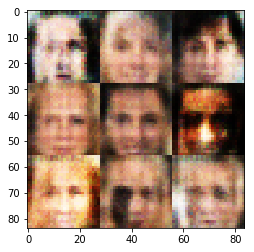

Step: 710: Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.4745
Step: 720: Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.4634
Step: 730: Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 1.6647
Step: 740: Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 2.2850
Step: 750: Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.9365
Step: 760: Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 1.4436
Step: 770: Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.5574
Step: 780: Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 1.6396
Step: 790: Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 1.1706
Step: 800: Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 1.3791


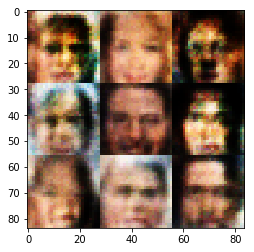

Step: 810: Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.6991
Step: 820: Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.3621
Step: 830: Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.4430
Step: 840: Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 1.1505
Step: 850: Epoch 1/1... Discriminator Loss: 0.7581... Generator Loss: 1.3870
Step: 860: Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.5089
Step: 870: Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 1.2190
Step: 880: Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 1.0902
Step: 890: Epoch 1/1... Discriminator Loss: 0.8544... Generator Loss: 1.4282
Step: 900: Epoch 1/1... Discriminator Loss: 0.8692... Generator Loss: 1.6027


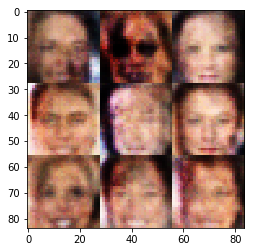

Step: 910: Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.5021
Step: 920: Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.5536
Step: 930: Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 2.3660
Step: 940: Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 0.9714
Step: 950: Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.5482
Step: 960: Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 2.3596
Step: 970: Epoch 1/1... Discriminator Loss: 1.6664... Generator Loss: 0.4038
Step: 980: Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 2.0520
Step: 990: Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.6275
Step: 1000: Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.5758


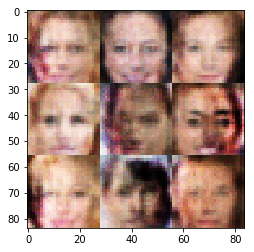

Step: 1010: Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 0.9474
Step: 1020: Epoch 1/1... Discriminator Loss: 1.8528... Generator Loss: 0.3011
Step: 1030: Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 2.1378
Step: 1040: Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 0.9660
Step: 1050: Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 2.1419
Step: 1060: Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 2.6384
Step: 1070: Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 1.0539
Step: 1080: Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.4901
Step: 1090: Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 2.5405
Step: 1100: Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.5571


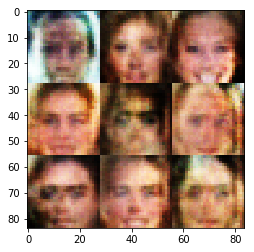

Step: 1110: Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.2744
Step: 1120: Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.7461
Step: 1130: Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 2.3654
Step: 1140: Epoch 1/1... Discriminator Loss: 0.8226... Generator Loss: 1.1143
Step: 1150: Epoch 1/1... Discriminator Loss: 1.5196... Generator Loss: 4.1164
Step: 1160: Epoch 1/1... Discriminator Loss: 0.8263... Generator Loss: 1.2595
Step: 1170: Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 0.8525
Step: 1180: Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 1.0863
Step: 1190: Epoch 1/1... Discriminator Loss: 0.6552... Generator Loss: 1.5129
Step: 1200: Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 2.6986


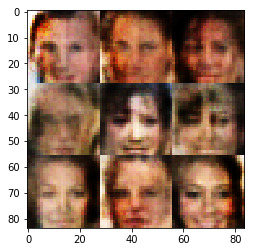

Step: 1210: Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.7263
Step: 1220: Epoch 1/1... Discriminator Loss: 1.9773... Generator Loss: 0.2520
Step: 1230: Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 1.7586
Step: 1240: Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 0.9490
Step: 1250: Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 2.8264
Step: 1260: Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.4413
Step: 1270: Epoch 1/1... Discriminator Loss: 1.7649... Generator Loss: 0.3498
Step: 1280: Epoch 1/1... Discriminator Loss: 1.9096... Generator Loss: 0.2635
Step: 1290: Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 0.7232
Step: 1300: Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 1.3161


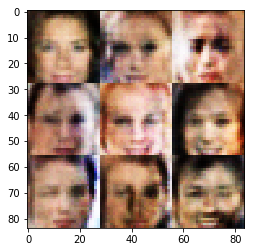

Step: 1310: Epoch 1/1... Discriminator Loss: 0.6127... Generator Loss: 1.7271
Step: 1320: Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 3.0953
Step: 1330: Epoch 1/1... Discriminator Loss: 0.5461... Generator Loss: 2.1314
Step: 1340: Epoch 1/1... Discriminator Loss: 0.7399... Generator Loss: 1.7431
Step: 1350: Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.5114
Step: 1360: Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.5182
Step: 1370: Epoch 1/1... Discriminator Loss: 0.7401... Generator Loss: 1.3188
Step: 1380: Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.2167
Step: 1390: Epoch 1/1... Discriminator Loss: 0.8051... Generator Loss: 1.0870
Step: 1400: Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 2.9938


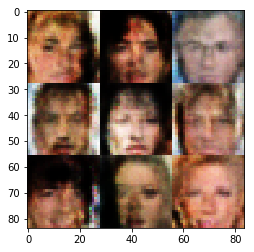

Step: 1410: Epoch 1/1... Discriminator Loss: 1.8190... Generator Loss: 1.8137
Step: 1420: Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 2.0773
Step: 1430: Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 2.4100
Step: 1440: Epoch 1/1... Discriminator Loss: 0.7825... Generator Loss: 2.2271
Step: 1450: Epoch 1/1... Discriminator Loss: 0.7035... Generator Loss: 1.3652
Step: 1460: Epoch 1/1... Discriminator Loss: 0.5913... Generator Loss: 2.3556
Step: 1470: Epoch 1/1... Discriminator Loss: 2.4735... Generator Loss: 3.7938
Step: 1480: Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.5054
Step: 1490: Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 2.0990
Step: 1500: Epoch 1/1... Discriminator Loss: 0.7774... Generator Loss: 3.4021


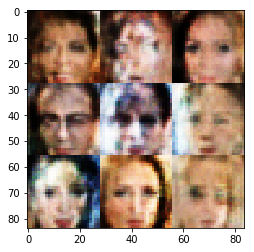

Step: 1510: Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 1.0028
Step: 1520: Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.4513
Step: 1530: Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.6775
Step: 1540: Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.5041
Step: 1550: Epoch 1/1... Discriminator Loss: 0.5511... Generator Loss: 2.6441
Step: 1560: Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 4.3798
Step: 1570: Epoch 1/1... Discriminator Loss: 0.5803... Generator Loss: 2.2355
Step: 1580: Epoch 1/1... Discriminator Loss: 0.5828... Generator Loss: 2.7058
Step: 1590: Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.4525
Step: 1600: Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.6042


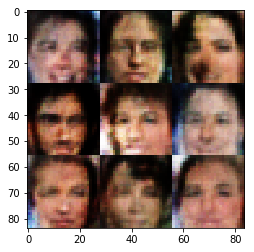

Step: 1610: Epoch 1/1... Discriminator Loss: 0.7438... Generator Loss: 1.2274
Step: 1620: Epoch 1/1... Discriminator Loss: 0.5717... Generator Loss: 3.8120
Step: 1630: Epoch 1/1... Discriminator Loss: 1.9571... Generator Loss: 0.2496
Step: 1640: Epoch 1/1... Discriminator Loss: 0.8330... Generator Loss: 1.1178
Step: 1650: Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 0.7275
Step: 1660: Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.4439
Step: 1670: Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 0.9577
Step: 1680: Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.6227
Step: 1690: Epoch 1/1... Discriminator Loss: 2.0072... Generator Loss: 0.2658
Step: 1700: Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 1.9761


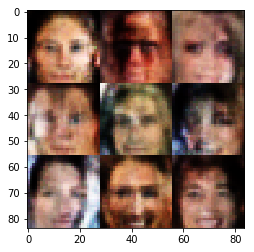

Step: 1710: Epoch 1/1... Discriminator Loss: 0.7199... Generator Loss: 1.3483
Step: 1720: Epoch 1/1... Discriminator Loss: 0.5524... Generator Loss: 2.9251
Step: 1730: Epoch 1/1... Discriminator Loss: 0.5350... Generator Loss: 2.4646
Step: 1740: Epoch 1/1... Discriminator Loss: 0.6893... Generator Loss: 2.1077
Step: 1750: Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 3.9668
Step: 1760: Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 2.8060
Step: 1770: Epoch 1/1... Discriminator Loss: 0.5161... Generator Loss: 1.9759
Step: 1780: Epoch 1/1... Discriminator Loss: 0.5322... Generator Loss: 3.2141
Step: 1790: Epoch 1/1... Discriminator Loss: 0.7040... Generator Loss: 3.7638
Step: 1800: Epoch 1/1... Discriminator Loss: 0.5823... Generator Loss: 1.7581


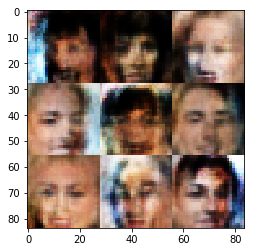

Step: 1810: Epoch 1/1... Discriminator Loss: 0.5192... Generator Loss: 2.8837
Step: 1820: Epoch 1/1... Discriminator Loss: 0.5127... Generator Loss: 2.0297
Step: 1830: Epoch 1/1... Discriminator Loss: 1.7667... Generator Loss: 0.3387
Step: 1840: Epoch 1/1... Discriminator Loss: 1.8928... Generator Loss: 0.2754
Step: 1850: Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 1.0212
Step: 1860: Epoch 1/1... Discriminator Loss: 2.1699... Generator Loss: 0.2167
Step: 1870: Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.5757
Step: 1880: Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 0.4315
Step: 1890: Epoch 1/1... Discriminator Loss: 0.7653... Generator Loss: 1.1964
Step: 1900: Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 0.8765


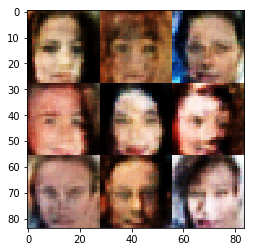

Step: 1910: Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 3.7561
Step: 1920: Epoch 1/1... Discriminator Loss: 0.5995... Generator Loss: 1.9175
Step: 1930: Epoch 1/1... Discriminator Loss: 2.3458... Generator Loss: 0.1857
Step: 1940: Epoch 1/1... Discriminator Loss: 0.7377... Generator Loss: 1.2976
Step: 1950: Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 1.6523
Step: 1960: Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 1.2989
Step: 1970: Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.7314
Step: 1980: Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 2.6193
Step: 1990: Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 1.2335
Step: 2000: Epoch 1/1... Discriminator Loss: 0.8714... Generator Loss: 0.9548


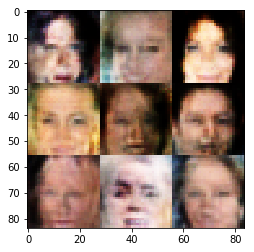

Step: 2010: Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 1.0886
Step: 2020: Epoch 1/1... Discriminator Loss: 0.7578... Generator Loss: 1.1725
Step: 2030: Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.4902
Step: 2040: Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.8229
Step: 2050: Epoch 1/1... Discriminator Loss: 0.6614... Generator Loss: 1.6015
Step: 2060: Epoch 1/1... Discriminator Loss: 0.6820... Generator Loss: 1.6382
Step: 2070: Epoch 1/1... Discriminator Loss: 0.5873... Generator Loss: 1.8462
Step: 2080: Epoch 1/1... Discriminator Loss: 0.5696... Generator Loss: 1.6908
Step: 2090: Epoch 1/1... Discriminator Loss: 0.6252... Generator Loss: 1.9632
Step: 2100: Epoch 1/1... Discriminator Loss: 0.5215... Generator Loss: 3.2231


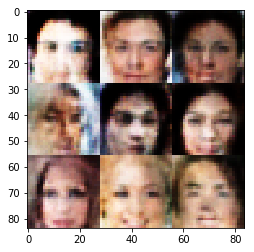

Step: 2110: Epoch 1/1... Discriminator Loss: 0.5952... Generator Loss: 1.6227
Step: 2120: Epoch 1/1... Discriminator Loss: 2.5345... Generator Loss: 0.1495
Step: 2130: Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.6494
Step: 2140: Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 0.8391
Step: 2150: Epoch 1/1... Discriminator Loss: 0.7017... Generator Loss: 1.4668
Step: 2160: Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.5709
Step: 2170: Epoch 1/1... Discriminator Loss: 0.6421... Generator Loss: 1.4245
Step: 2180: Epoch 1/1... Discriminator Loss: 0.4696... Generator Loss: 2.2273
Step: 2190: Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 3.8491
Step: 2200: Epoch 1/1... Discriminator Loss: 0.4891... Generator Loss: 2.0380


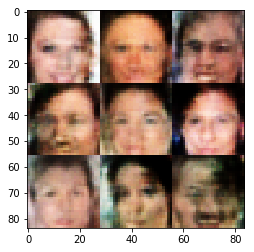

Step: 2210: Epoch 1/1... Discriminator Loss: 0.4633... Generator Loss: 3.0175
Step: 2220: Epoch 1/1... Discriminator Loss: 0.4801... Generator Loss: 2.1960
Step: 2230: Epoch 1/1... Discriminator Loss: 0.4809... Generator Loss: 2.1834
Step: 2240: Epoch 1/1... Discriminator Loss: 0.7548... Generator Loss: 2.6095
Step: 2250: Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 2.1335
Step: 2260: Epoch 1/1... Discriminator Loss: 2.0526... Generator Loss: 3.7232
Step: 2270: Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 1.1089
Step: 2280: Epoch 1/1... Discriminator Loss: 0.8420... Generator Loss: 2.4393
Step: 2290: Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.7617
Step: 2300: Epoch 1/1... Discriminator Loss: 0.6400... Generator Loss: 1.7856


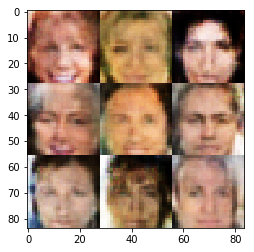

Step: 2310: Epoch 1/1... Discriminator Loss: 0.4741... Generator Loss: 2.3173
Step: 2320: Epoch 1/1... Discriminator Loss: 0.5868... Generator Loss: 2.0358
Step: 2330: Epoch 1/1... Discriminator Loss: 0.5855... Generator Loss: 2.1142
Step: 2340: Epoch 1/1... Discriminator Loss: 0.6789... Generator Loss: 1.7626
Step: 2350: Epoch 1/1... Discriminator Loss: 0.5371... Generator Loss: 2.0528
Step: 2360: Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 2.2056
Step: 2370: Epoch 1/1... Discriminator Loss: 0.5862... Generator Loss: 1.9774
Step: 2380: Epoch 1/1... Discriminator Loss: 0.4325... Generator Loss: 2.5748
Step: 2390: Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.6655
Step: 2400: Epoch 1/1... Discriminator Loss: 0.5674... Generator Loss: 1.9307


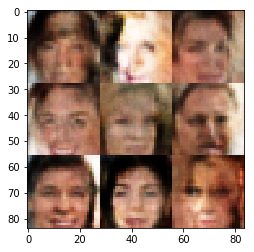

Step: 2410: Epoch 1/1... Discriminator Loss: 2.2517... Generator Loss: 0.1924
Step: 2420: Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 1.3761
Step: 2430: Epoch 1/1... Discriminator Loss: 0.8175... Generator Loss: 1.1464
Step: 2440: Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 1.7483
Step: 2450: Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 1.3392
Step: 2460: Epoch 1/1... Discriminator Loss: 0.5805... Generator Loss: 2.0602
Step: 2470: Epoch 1/1... Discriminator Loss: 0.8287... Generator Loss: 1.0458
Step: 2480: Epoch 1/1... Discriminator Loss: 0.5994... Generator Loss: 1.6084
Step: 2490: Epoch 1/1... Discriminator Loss: 0.5019... Generator Loss: 2.1399
Step: 2500: Epoch 1/1... Discriminator Loss: 0.4751... Generator Loss: 3.1491


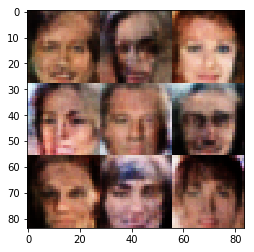

Step: 2510: Epoch 1/1... Discriminator Loss: 1.8103... Generator Loss: 4.9106
Step: 2520: Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.7770
Step: 2530: Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 1.2769
Step: 2540: Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 0.8148
Step: 2550: Epoch 1/1... Discriminator Loss: 0.5346... Generator Loss: 1.9798
Step: 2560: Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.8314
Step: 2570: Epoch 1/1... Discriminator Loss: 0.7746... Generator Loss: 1.1739
Step: 2580: Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 0.8825
Step: 2590: Epoch 1/1... Discriminator Loss: 0.5169... Generator Loss: 2.2196
Step: 2600: Epoch 1/1... Discriminator Loss: 0.4575... Generator Loss: 2.5373


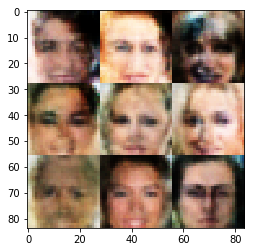

Step: 2610: Epoch 1/1... Discriminator Loss: 2.1093... Generator Loss: 0.2308
Step: 2620: Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.4861
Step: 2630: Epoch 1/1... Discriminator Loss: 0.4912... Generator Loss: 2.2480
Step: 2640: Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 2.3630
Step: 2650: Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.8356
Step: 2660: Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 1.9102
Step: 2670: Epoch 1/1... Discriminator Loss: 0.5719... Generator Loss: 1.9160
Step: 2680: Epoch 1/1... Discriminator Loss: 0.4649... Generator Loss: 3.6105
Step: 2690: Epoch 1/1... Discriminator Loss: 0.4144... Generator Loss: 2.7186
Step: 2700: Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 1.5215


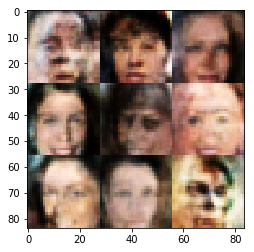

Step: 2710: Epoch 1/1... Discriminator Loss: 0.5167... Generator Loss: 2.4428
Step: 2720: Epoch 1/1... Discriminator Loss: 0.5997... Generator Loss: 1.6472
Step: 2730: Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 1.1239
Step: 2740: Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 3.4662
Step: 2750: Epoch 1/1... Discriminator Loss: 0.6929... Generator Loss: 1.8171
Step: 2760: Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 2.8932
Step: 2770: Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 2.9252
Step: 2780: Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 1.6948
Step: 2790: Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 1.0389
Step: 2800: Epoch 1/1... Discriminator Loss: 0.7779... Generator Loss: 1.6883


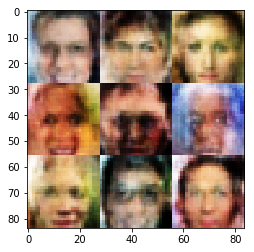

Step: 2810: Epoch 1/1... Discriminator Loss: 0.5498... Generator Loss: 2.3120
Step: 2820: Epoch 1/1... Discriminator Loss: 1.5907... Generator Loss: 0.4140
Step: 2830: Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 1.2091
Step: 2840: Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 1.9954
Step: 2850: Epoch 1/1... Discriminator Loss: 0.5194... Generator Loss: 2.3510
Step: 2860: Epoch 1/1... Discriminator Loss: 0.5314... Generator Loss: 1.8689
Step: 2870: Epoch 1/1... Discriminator Loss: 0.4444... Generator Loss: 3.0427
Step: 2880: Epoch 1/1... Discriminator Loss: 1.7293... Generator Loss: 0.3399
Step: 2890: Epoch 1/1... Discriminator Loss: 0.6104... Generator Loss: 1.5912
Step: 2900: Epoch 1/1... Discriminator Loss: 0.6046... Generator Loss: 2.2983


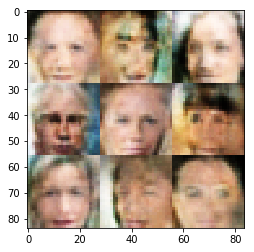

Step: 2910: Epoch 1/1... Discriminator Loss: 0.6098... Generator Loss: 1.9313
Step: 2920: Epoch 1/1... Discriminator Loss: 0.4241... Generator Loss: 2.9339
Step: 2930: Epoch 1/1... Discriminator Loss: 0.5768... Generator Loss: 1.8897
Step: 2940: Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 1.2946
Step: 2950: Epoch 1/1... Discriminator Loss: 0.6642... Generator Loss: 1.4025
Step: 2960: Epoch 1/1... Discriminator Loss: 0.6689... Generator Loss: 1.3454
Step: 2970: Epoch 1/1... Discriminator Loss: 0.6712... Generator Loss: 1.4682
Step: 2980: Epoch 1/1... Discriminator Loss: 0.6339... Generator Loss: 1.7631
Step: 2990: Epoch 1/1... Discriminator Loss: 0.7317... Generator Loss: 1.2801
Step: 3000: Epoch 1/1... Discriminator Loss: 0.7569... Generator Loss: 1.1865


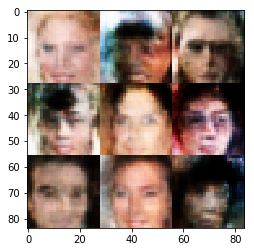

Step: 3010: Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.5172
Step: 3020: Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 1.0021
Step: 3030: Epoch 1/1... Discriminator Loss: 0.5788... Generator Loss: 1.7812
Step: 3040: Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.6635
Step: 3050: Epoch 1/1... Discriminator Loss: 0.4466... Generator Loss: 2.6355
Step: 3060: Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 0.8992
Step: 3070: Epoch 1/1... Discriminator Loss: 0.7604... Generator Loss: 1.1941
Step: 3080: Epoch 1/1... Discriminator Loss: 0.5217... Generator Loss: 2.7053
Step: 3090: Epoch 1/1... Discriminator Loss: 0.6140... Generator Loss: 1.5686
Step: 3100: Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 0.7275


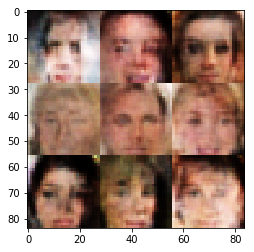

Step: 3110: Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 1.7805
Step: 3120: Epoch 1/1... Discriminator Loss: 0.5601... Generator Loss: 1.9202
Step: 3130: Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.6244
Step: 3140: Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 1.1390
Step: 3150: Epoch 1/1... Discriminator Loss: 0.6558... Generator Loss: 1.4840
Step: 3160: Epoch 1/1... Discriminator Loss: 0.5859... Generator Loss: 2.0250
Step: 3170: Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 2.7593
Step: 3180: Epoch 1/1... Discriminator Loss: 0.5365... Generator Loss: 1.8856
Step: 3190: Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.6438
Step: 3200: Epoch 1/1... Discriminator Loss: 0.5838... Generator Loss: 2.0450


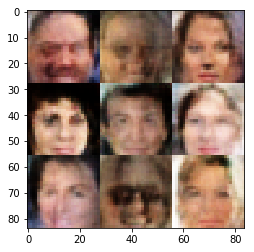

Step: 3210: Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.5736
Step: 3220: Epoch 1/1... Discriminator Loss: 0.5710... Generator Loss: 2.8304
Step: 3230: Epoch 1/1... Discriminator Loss: 0.5824... Generator Loss: 2.4305
Step: 3240: Epoch 1/1... Discriminator Loss: 0.6025... Generator Loss: 1.6591
Step: 3250: Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 2.4238
Step: 3260: Epoch 1/1... Discriminator Loss: 0.5157... Generator Loss: 3.0387
Step: 3270: Epoch 1/1... Discriminator Loss: 0.5592... Generator Loss: 1.8227
Step: 3280: Epoch 1/1... Discriminator Loss: 0.4671... Generator Loss: 3.0252
Step: 3290: Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 2.4592
Step: 3300: Epoch 1/1... Discriminator Loss: 0.4584... Generator Loss: 2.5278


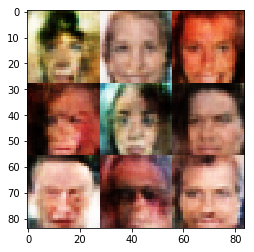

Step: 3310: Epoch 1/1... Discriminator Loss: 0.3855... Generator Loss: 3.2232
Step: 3320: Epoch 1/1... Discriminator Loss: 0.5304... Generator Loss: 2.0547
Step: 3330: Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 1.0495
Step: 3340: Epoch 1/1... Discriminator Loss: 0.6391... Generator Loss: 1.5737
Step: 3350: Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 4.5621
Step: 3360: Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.7005
Step: 3370: Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 1.3252
Step: 3380: Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 1.5763
Step: 3390: Epoch 1/1... Discriminator Loss: 0.5275... Generator Loss: 2.1158
Step: 3400: Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 2.3312


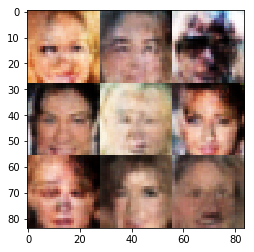

Step: 3410: Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 1.1446
Step: 3420: Epoch 1/1... Discriminator Loss: 0.6645... Generator Loss: 1.8782
Step: 3430: Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 2.9224
Step: 3440: Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.1559
Step: 3450: Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 0.7961
Step: 3460: Epoch 1/1... Discriminator Loss: 0.5832... Generator Loss: 2.2351
Step: 3470: Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.6293
Step: 3480: Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 2.9849
Step: 3490: Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 3.3774
Step: 3500: Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 0.8769


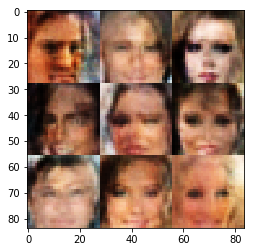

Step: 3510: Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.6413
Step: 3520: Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.4844
Step: 3530: Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 1.0183
Step: 3540: Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.6726
Step: 3550: Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.7218
Step: 3560: Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.0474
Step: 3570: Epoch 1/1... Discriminator Loss: 0.4631... Generator Loss: 2.5293
Step: 3580: Epoch 1/1... Discriminator Loss: 1.7131... Generator Loss: 0.4211
Step: 3590: Epoch 1/1... Discriminator Loss: 0.3973... Generator Loss: 3.6407
Step: 3600: Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.6737


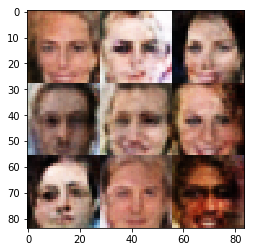

Step: 3610: Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 0.9022
Step: 3620: Epoch 1/1... Discriminator Loss: 0.4188... Generator Loss: 2.9414
Step: 3630: Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 0.9424
Step: 3640: Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.7709
Step: 3650: Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 0.8108
Step: 3660: Epoch 1/1... Discriminator Loss: 0.6619... Generator Loss: 1.5955
Step: 3670: Epoch 1/1... Discriminator Loss: 0.6048... Generator Loss: 1.8515
Step: 3680: Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.7453
Step: 3690: Epoch 1/1... Discriminator Loss: 0.8140... Generator Loss: 2.5212
Step: 3700: Epoch 1/1... Discriminator Loss: 0.5044... Generator Loss: 3.4209


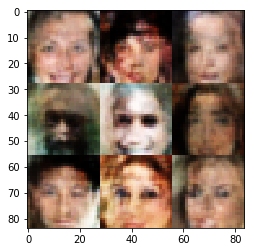

Step: 3710: Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 2.1942
Step: 3720: Epoch 1/1... Discriminator Loss: 0.4561... Generator Loss: 3.7969
Step: 3730: Epoch 1/1... Discriminator Loss: 0.5564... Generator Loss: 1.9910
Step: 3740: Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 1.2733
Step: 3750: Epoch 1/1... Discriminator Loss: 0.5947... Generator Loss: 1.6829
Step: 3760: Epoch 1/1... Discriminator Loss: 0.4467... Generator Loss: 2.5347
Step: 3770: Epoch 1/1... Discriminator Loss: 0.4795... Generator Loss: 2.4680
Step: 3780: Epoch 1/1... Discriminator Loss: 0.6737... Generator Loss: 2.6400
Step: 3790: Epoch 1/1... Discriminator Loss: 0.8518... Generator Loss: 1.7089
Step: 3800: Epoch 1/1... Discriminator Loss: 0.8761... Generator Loss: 1.1982


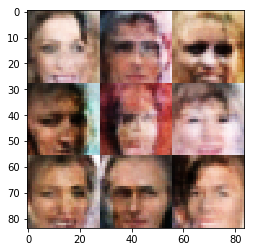

Step: 3810: Epoch 1/1... Discriminator Loss: 0.5610... Generator Loss: 1.9323
Step: 3820: Epoch 1/1... Discriminator Loss: 0.4608... Generator Loss: 2.8303
Step: 3830: Epoch 1/1... Discriminator Loss: 0.5031... Generator Loss: 2.3314
Step: 3840: Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 0.7979
Step: 3850: Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.7515
Step: 3860: Epoch 1/1... Discriminator Loss: 0.6589... Generator Loss: 1.5854
Step: 3870: Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 2.0715
Step: 3880: Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 3.7914
Step: 3890: Epoch 1/1... Discriminator Loss: 0.6037... Generator Loss: 1.9051
Step: 3900: Epoch 1/1... Discriminator Loss: 0.6600... Generator Loss: 1.6779


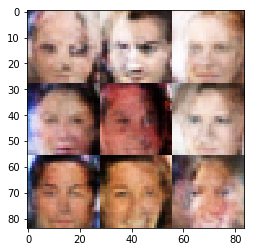

Step: 3910: Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 0.8698
Step: 3920: Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 1.8067
Step: 3930: Epoch 1/1... Discriminator Loss: 0.5196... Generator Loss: 2.2616
Step: 3940: Epoch 1/1... Discriminator Loss: 1.9395... Generator Loss: 0.3398
Step: 3950: Epoch 1/1... Discriminator Loss: 0.5596... Generator Loss: 2.1307
Step: 3960: Epoch 1/1... Discriminator Loss: 0.6548... Generator Loss: 1.4376
Step: 3970: Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.6380
Step: 3980: Epoch 1/1... Discriminator Loss: 0.4396... Generator Loss: 4.7852
Step: 3990: Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 0.8604
Step: 4000: Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 2.6958


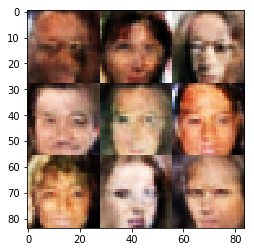

Step: 4010: Epoch 1/1... Discriminator Loss: 0.4891... Generator Loss: 2.0914
Step: 4020: Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 1.1363
Step: 4030: Epoch 1/1... Discriminator Loss: 0.7407... Generator Loss: 2.7583
Step: 4040: Epoch 1/1... Discriminator Loss: 0.4766... Generator Loss: 2.3693
Step: 4050: Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.5935
Step: 4060: Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 1.4477
Step: 4070: Epoch 1/1... Discriminator Loss: 0.5809... Generator Loss: 1.7730
Step: 4080: Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 1.3820
Step: 4090: Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 1.3792
Step: 4100: Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.1010


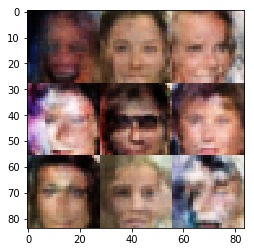

Step: 4110: Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 1.3495
Step: 4120: Epoch 1/1... Discriminator Loss: 0.7151... Generator Loss: 1.2497
Step: 4130: Epoch 1/1... Discriminator Loss: 0.7226... Generator Loss: 2.2669
Step: 4140: Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 1.8298
Step: 4150: Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.6483
Step: 4160: Epoch 1/1... Discriminator Loss: 0.4893... Generator Loss: 4.4627
Step: 4170: Epoch 1/1... Discriminator Loss: 0.5862... Generator Loss: 1.8868
Step: 4180: Epoch 1/1... Discriminator Loss: 0.5838... Generator Loss: 2.2014
Step: 4190: Epoch 1/1... Discriminator Loss: 0.5414... Generator Loss: 2.0194
Step: 4200: Epoch 1/1... Discriminator Loss: 1.8811... Generator Loss: 0.3842


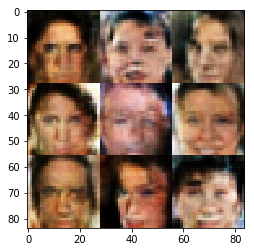

Step: 4210: Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 1.3647
Step: 4220: Epoch 1/1... Discriminator Loss: 0.6624... Generator Loss: 1.6250
Step: 4230: Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 1.0913
Step: 4240: Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 2.2896
Step: 4250: Epoch 1/1... Discriminator Loss: 0.4580... Generator Loss: 2.7031
Step: 4260: Epoch 1/1... Discriminator Loss: 0.6882... Generator Loss: 1.4136
Step: 4270: Epoch 1/1... Discriminator Loss: 0.5822... Generator Loss: 1.9342
Step: 4280: Epoch 1/1... Discriminator Loss: 0.5611... Generator Loss: 1.9505
Step: 4290: Epoch 1/1... Discriminator Loss: 0.4142... Generator Loss: 3.7414
Step: 4300: Epoch 1/1... Discriminator Loss: 0.5404... Generator Loss: 2.1170


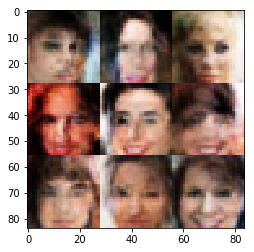

Step: 4310: Epoch 1/1... Discriminator Loss: 0.6606... Generator Loss: 2.4915
Step: 4320: Epoch 1/1... Discriminator Loss: 0.7305... Generator Loss: 1.2742
Step: 4330: Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 2.8719
Step: 4340: Epoch 1/1... Discriminator Loss: 0.5605... Generator Loss: 1.7296
Step: 4350: Epoch 1/1... Discriminator Loss: 2.1780... Generator Loss: 0.2594
Step: 4360: Epoch 1/1... Discriminator Loss: 0.5014... Generator Loss: 2.9934
Step: 4370: Epoch 1/1... Discriminator Loss: 0.6869... Generator Loss: 2.1242
Step: 4380: Epoch 1/1... Discriminator Loss: 0.5349... Generator Loss: 2.5564
Step: 4390: Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 1.0683
Step: 4400: Epoch 1/1... Discriminator Loss: 0.4207... Generator Loss: 3.2682


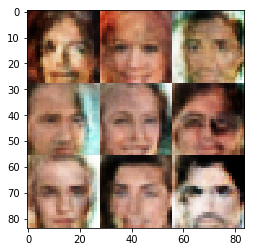

Step: 4410: Epoch 1/1... Discriminator Loss: 0.5327... Generator Loss: 1.9331
Step: 4420: Epoch 1/1... Discriminator Loss: 0.4570... Generator Loss: 2.4519
Step: 4430: Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 1.4353
Step: 4440: Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 2.3580
Step: 4450: Epoch 1/1... Discriminator Loss: 0.7204... Generator Loss: 1.5917
Step: 4460: Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 1.0514
Step: 4470: Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 1.0251
Step: 4480: Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 1.3460
Step: 4490: Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.6062
Step: 4500: Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 0.9928


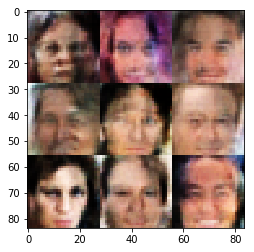

Step: 4510: Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 2.4371
Step: 4520: Epoch 1/1... Discriminator Loss: 0.6415... Generator Loss: 1.9060
Step: 4530: Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 1.2259
Step: 4540: Epoch 1/1... Discriminator Loss: 0.6177... Generator Loss: 1.6405
Step: 4550: Epoch 1/1... Discriminator Loss: 0.6609... Generator Loss: 1.4723
Step: 4560: Epoch 1/1... Discriminator Loss: 0.4155... Generator Loss: 3.2546
Step: 4570: Epoch 1/1... Discriminator Loss: 0.5789... Generator Loss: 2.7453
Step: 4580: Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 1.0958
Step: 4590: Epoch 1/1... Discriminator Loss: 1.6561... Generator Loss: 0.4038
Step: 4600: Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 1.5652


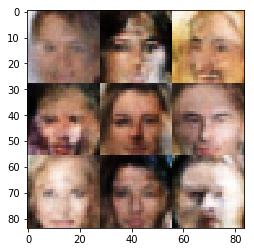

Step: 4610: Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 2.1663
Step: 4620: Epoch 1/1... Discriminator Loss: 0.9192... Generator Loss: 1.0574
Step: 4630: Epoch 1/1... Discriminator Loss: 0.7419... Generator Loss: 1.3293
Step: 4640: Epoch 1/1... Discriminator Loss: 0.6415... Generator Loss: 1.5548
Step: 4650: Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.8184
Step: 4660: Epoch 1/1... Discriminator Loss: 0.7212... Generator Loss: 1.4410
Step: 4670: Epoch 1/1... Discriminator Loss: 2.2647... Generator Loss: 0.2675
Step: 4680: Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.8662
Step: 4690: Epoch 1/1... Discriminator Loss: 0.9278... Generator Loss: 0.9974
Step: 4700: Epoch 1/1... Discriminator Loss: 0.7293... Generator Loss: 1.2158


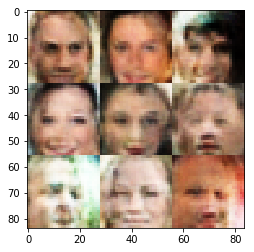

Step: 4710: Epoch 1/1... Discriminator Loss: 0.5375... Generator Loss: 2.1235
Step: 4720: Epoch 1/1... Discriminator Loss: 0.5720... Generator Loss: 1.8890
Step: 4730: Epoch 1/1... Discriminator Loss: 0.6126... Generator Loss: 2.1880
Step: 4740: Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 1.3313
Step: 4750: Epoch 1/1... Discriminator Loss: 0.4623... Generator Loss: 2.3738
Step: 4760: Epoch 1/1... Discriminator Loss: 0.6514... Generator Loss: 3.1537
Step: 4770: Epoch 1/1... Discriminator Loss: 0.6174... Generator Loss: 1.7188
Step: 4780: Epoch 1/1... Discriminator Loss: 0.4605... Generator Loss: 2.3932
Step: 4790: Epoch 1/1... Discriminator Loss: 5.0742... Generator Loss: 6.9605
Step: 4800: Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.5971


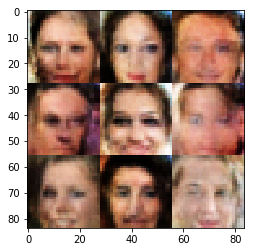

Step: 4810: Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 0.7559
Step: 4820: Epoch 1/1... Discriminator Loss: 0.7407... Generator Loss: 1.3154
Step: 4830: Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 0.9021
Step: 4840: Epoch 1/1... Discriminator Loss: 0.6345... Generator Loss: 1.6757
Step: 4850: Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.6226
Step: 4860: Epoch 1/1... Discriminator Loss: 0.7657... Generator Loss: 1.2196
Step: 4870: Epoch 1/1... Discriminator Loss: 0.5175... Generator Loss: 2.1357
Step: 4880: Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 3.2504
Step: 4890: Epoch 1/1... Discriminator Loss: 0.4877... Generator Loss: 2.6224
Step: 4900: Epoch 1/1... Discriminator Loss: 0.6957... Generator Loss: 1.4003


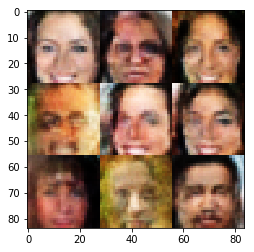

Step: 4910: Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 1.5117
Step: 4920: Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.6639
Step: 4930: Epoch 1/1... Discriminator Loss: 0.3486... Generator Loss: 5.3824
Step: 4940: Epoch 1/1... Discriminator Loss: 0.6892... Generator Loss: 1.6617
Step: 4950: Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 3.6030
Step: 4960: Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.6251
Step: 4970: Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.5767
Step: 4980: Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.6810
Step: 4990: Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 1.4410
Step: 5000: Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 1.2810


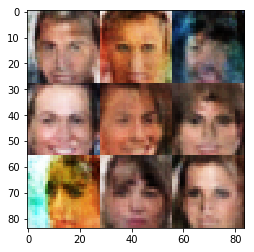

Step: 5010: Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 2.8233
Step: 5020: Epoch 1/1... Discriminator Loss: 0.4677... Generator Loss: 2.5437
Step: 5030: Epoch 1/1... Discriminator Loss: 0.6691... Generator Loss: 2.0684
Step: 5040: Epoch 1/1... Discriminator Loss: 0.4670... Generator Loss: 2.6071
Step: 5050: Epoch 1/1... Discriminator Loss: 0.5837... Generator Loss: 2.7527
Step: 5060: Epoch 1/1... Discriminator Loss: 0.4886... Generator Loss: 2.3689
Step: 5070: Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 3.7759
Step: 5080: Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.6780
Step: 5090: Epoch 1/1... Discriminator Loss: 0.6853... Generator Loss: 1.3497
Step: 5100: Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 2.6736


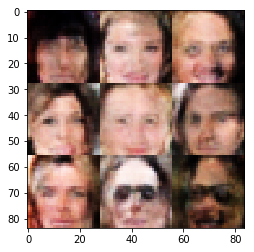

Step: 5110: Epoch 1/1... Discriminator Loss: 0.4504... Generator Loss: 2.6272
Step: 5120: Epoch 1/1... Discriminator Loss: 0.4173... Generator Loss: 3.1610
Step: 5130: Epoch 1/1... Discriminator Loss: 0.5810... Generator Loss: 2.0660
Step: 5140: Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 0.8905
Step: 5150: Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 1.2269
Step: 5160: Epoch 1/1... Discriminator Loss: 0.5177... Generator Loss: 2.1615
Step: 5170: Epoch 1/1... Discriminator Loss: 0.6043... Generator Loss: 1.6213
Step: 5180: Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 1.7397
Step: 5190: Epoch 1/1... Discriminator Loss: 0.5342... Generator Loss: 2.1227
Step: 5200: Epoch 1/1... Discriminator Loss: 0.6383... Generator Loss: 1.5781


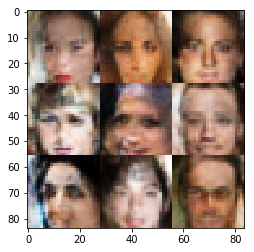

Step: 5210: Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 0.7951
Step: 5220: Epoch 1/1... Discriminator Loss: 0.4602... Generator Loss: 2.8806
Step: 5230: Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.9173
Step: 5240: Epoch 1/1... Discriminator Loss: 0.5189... Generator Loss: 2.1550
Step: 5250: Epoch 1/1... Discriminator Loss: 0.5571... Generator Loss: 1.9102
Step: 5260: Epoch 1/1... Discriminator Loss: 0.5338... Generator Loss: 2.2318
Step: 5270: Epoch 1/1... Discriminator Loss: 0.5491... Generator Loss: 1.7660
Step: 5280: Epoch 1/1... Discriminator Loss: 0.4066... Generator Loss: 3.7790
Step: 5290: Epoch 1/1... Discriminator Loss: 0.4362... Generator Loss: 2.7198
Step: 5300: Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 3.0772


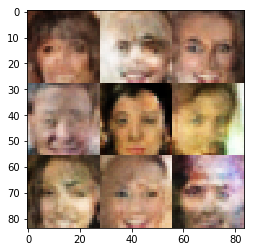

Step: 5310: Epoch 1/1... Discriminator Loss: 2.7663... Generator Loss: 0.1666
Step: 5320: Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.6290
Step: 5330: Epoch 1/1... Discriminator Loss: 1.5972... Generator Loss: 3.6593
Step: 5340: Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.1414
Step: 5350: Epoch 1/1... Discriminator Loss: 0.7014... Generator Loss: 1.3213
Step: 5360: Epoch 1/1... Discriminator Loss: 0.6359... Generator Loss: 1.7884
Step: 5370: Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.6410
Step: 5380: Epoch 1/1... Discriminator Loss: 0.5290... Generator Loss: 2.0654
Step: 5390: Epoch 1/1... Discriminator Loss: 0.5429... Generator Loss: 1.9472
Step: 5400: Epoch 1/1... Discriminator Loss: 0.4682... Generator Loss: 3.2653


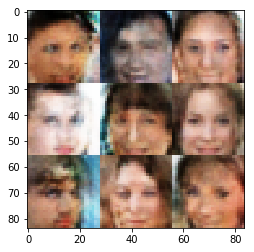

Step: 5410: Epoch 1/1... Discriminator Loss: 0.4090... Generator Loss: 3.6434
Step: 5420: Epoch 1/1... Discriminator Loss: 0.5116... Generator Loss: 2.4344
Step: 5430: Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 1.1854
Step: 5440: Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 2.2150
Step: 5450: Epoch 1/1... Discriminator Loss: 0.4672... Generator Loss: 2.5015
Step: 5460: Epoch 1/1... Discriminator Loss: 0.4102... Generator Loss: 3.5472
Step: 5470: Epoch 1/1... Discriminator Loss: 0.7470... Generator Loss: 1.3141
Step: 5480: Epoch 1/1... Discriminator Loss: 1.8568... Generator Loss: 0.3572
Step: 5490: Epoch 1/1... Discriminator Loss: 0.6462... Generator Loss: 2.1142
Step: 5500: Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.5221


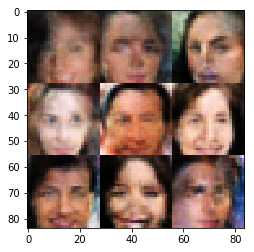

Step: 5510: Epoch 1/1... Discriminator Loss: 0.5571... Generator Loss: 2.2054
Step: 5520: Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 1.3543
Step: 5530: Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 1.4335
Step: 5540: Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 3.2000
Step: 5550: Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 0.9236
Step: 5560: Epoch 1/1... Discriminator Loss: 0.6180... Generator Loss: 1.6586
Step: 5570: Epoch 1/1... Discriminator Loss: 0.6453... Generator Loss: 1.7847
Step: 5580: Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.2797
Step: 5590: Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 1.3107
Step: 5600: Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 2.7846


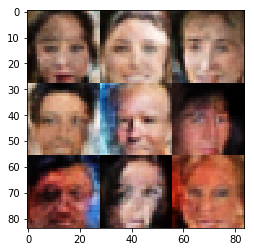

Step: 5610: Epoch 1/1... Discriminator Loss: 0.7228... Generator Loss: 1.3423
Step: 5620: Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 1.7408
Step: 5630: Epoch 1/1... Discriminator Loss: 0.5597... Generator Loss: 1.8120
Step: 5640: Epoch 1/1... Discriminator Loss: 0.5399... Generator Loss: 2.0604
Step: 5650: Epoch 1/1... Discriminator Loss: 0.5089... Generator Loss: 2.1077
Step: 5660: Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.5827
Step: 5670: Epoch 1/1... Discriminator Loss: 0.6555... Generator Loss: 1.4921
Step: 5680: Epoch 1/1... Discriminator Loss: 0.5489... Generator Loss: 1.8960
Step: 5690: Epoch 1/1... Discriminator Loss: 0.5647... Generator Loss: 1.8044
Step: 5700: Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.6575


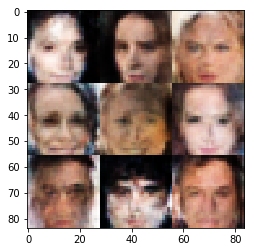

Step: 5710: Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 2.9502
Step: 5720: Epoch 1/1... Discriminator Loss: 0.5461... Generator Loss: 2.8512
Step: 5730: Epoch 1/1... Discriminator Loss: 0.5536... Generator Loss: 1.9451
Step: 5740: Epoch 1/1... Discriminator Loss: 0.4874... Generator Loss: 4.7438
Step: 5750: Epoch 1/1... Discriminator Loss: 0.5196... Generator Loss: 2.0567
Step: 5760: Epoch 1/1... Discriminator Loss: 0.4058... Generator Loss: 3.4066
Step: 5770: Epoch 1/1... Discriminator Loss: 0.4948... Generator Loss: 2.2639
Step: 5780: Epoch 1/1... Discriminator Loss: 0.4550... Generator Loss: 2.5950
Step: 5790: Epoch 1/1... Discriminator Loss: 0.6649... Generator Loss: 1.4322
Step: 5800: Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.6277


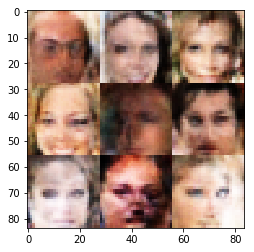

Step: 5810: Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 2.0312
Step: 5820: Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 1.4176
Step: 5830: Epoch 1/1... Discriminator Loss: 0.6480... Generator Loss: 2.3240
Step: 5840: Epoch 1/1... Discriminator Loss: 0.6247... Generator Loss: 1.6258
Step: 5850: Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 2.1375
Step: 5860: Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 5.3509
Step: 5870: Epoch 1/1... Discriminator Loss: 1.9848... Generator Loss: 0.2898
Step: 5880: Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 1.1843
Step: 5890: Epoch 1/1... Discriminator Loss: 0.4548... Generator Loss: 2.8620
Step: 5900: Epoch 1/1... Discriminator Loss: 0.5876... Generator Loss: 1.7085


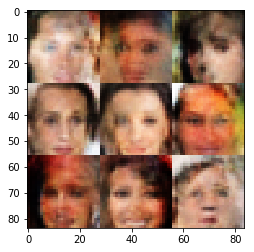

Step: 5910: Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 1.2850
Step: 5920: Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.8402
Step: 5930: Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 1.0309
Step: 5940: Epoch 1/1... Discriminator Loss: 0.8513... Generator Loss: 1.0432
Step: 5950: Epoch 1/1... Discriminator Loss: 0.5936... Generator Loss: 1.6972
Step: 5960: Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 0.9089
Step: 5970: Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 3.2529
Step: 5980: Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 1.3006
Step: 5990: Epoch 1/1... Discriminator Loss: 0.4348... Generator Loss: 2.7541
Step: 6000: Epoch 1/1... Discriminator Loss: 0.6971... Generator Loss: 1.7629


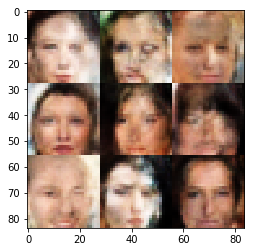

Step: 6010: Epoch 1/1... Discriminator Loss: 0.5508... Generator Loss: 1.7931
Step: 6020: Epoch 1/1... Discriminator Loss: 0.7580... Generator Loss: 1.3605
Step: 6030: Epoch 1/1... Discriminator Loss: 2.2399... Generator Loss: 0.2142
Step: 6040: Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 1.6511
Step: 6050: Epoch 1/1... Discriminator Loss: 0.6097... Generator Loss: 1.5985
Step: 6060: Epoch 1/1... Discriminator Loss: 0.4667... Generator Loss: 2.8261
Step: 6070: Epoch 1/1... Discriminator Loss: 0.5832... Generator Loss: 1.8129
Step: 6080: Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 3.6043
Step: 6090: Epoch 1/1... Discriminator Loss: 0.7097... Generator Loss: 1.3201
Step: 6100: Epoch 1/1... Discriminator Loss: 0.8251... Generator Loss: 1.0443


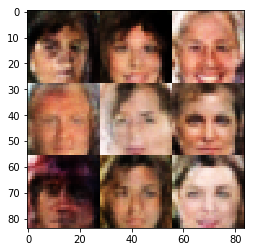

Step: 6110: Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.1267
Step: 6120: Epoch 1/1... Discriminator Loss: 0.5029... Generator Loss: 2.2144
Step: 6130: Epoch 1/1... Discriminator Loss: 0.4280... Generator Loss: 2.9959
Step: 6140: Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 3.0468
Step: 6150: Epoch 1/1... Discriminator Loss: 2.8147... Generator Loss: 0.1350
Step: 6160: Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 1.9014
Step: 6170: Epoch 1/1... Discriminator Loss: 1.9785... Generator Loss: 0.2851
Step: 6180: Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 1.2046
Step: 6190: Epoch 1/1... Discriminator Loss: 0.6696... Generator Loss: 1.4316
Step: 6200: Epoch 1/1... Discriminator Loss: 0.6037... Generator Loss: 1.6502


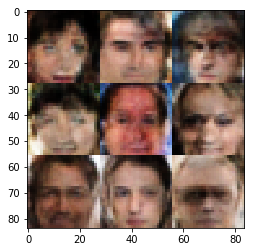

Step: 6210: Epoch 1/1... Discriminator Loss: 0.5660... Generator Loss: 3.3921
Step: 6220: Epoch 1/1... Discriminator Loss: 0.5744... Generator Loss: 1.8533
Step: 6230: Epoch 1/1... Discriminator Loss: 0.5441... Generator Loss: 1.8741
Step: 6240: Epoch 1/1... Discriminator Loss: 0.6894... Generator Loss: 1.3315
Step: 6250: Epoch 1/1... Discriminator Loss: 2.8856... Generator Loss: 0.1414
Step: 6260: Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 0.7917
Step: 6270: Epoch 1/1... Discriminator Loss: 0.8993... Generator Loss: 0.9871
Step: 6280: Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.6527
Step: 6290: Epoch 1/1... Discriminator Loss: 0.6911... Generator Loss: 1.4086
Step: 6300: Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 0.9437


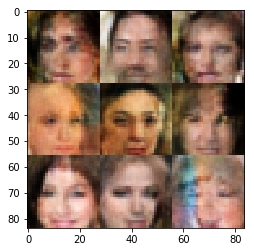

Step: 6310: Epoch 1/1... Discriminator Loss: 0.5419... Generator Loss: 1.9527
Step: 6320: Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 1.1299
Step: 6330: Epoch 1/1... Discriminator Loss: 0.5609... Generator Loss: 1.8787
Finished the training


In [20]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.